# cis-sQTL analysis
After nominal pass:
- 1. Determine optimal #HCP from nominal associations
- 2. Visualize expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:
- 3. check beta approximated permutation pval
- 4. QTL TSS distance density plot
- 5. Intron annotation: GTEx and Leafviz
- 6. Compare sig feature across ancestries, upsetR
- 7: Conditional pass
- 8: **TODO** Susie finemapping

In [3]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(VennDiagram))
suppressMessages(library(UpSetR))
# suppressMessages(library(ggridges))
# suppressMessages(library(patchwork))
suppressMessages(library(qvalue))
library(ggsignif)
library(ggsci)

In [4]:
setwd("~/project-gandalm/isoform_twas/sqtl_new/")

### 1: Optimal number of HCP

In [3]:
options(repr.plot.width = 6, repr.plot.height = 6)
df_all <- data.frame("HCP" = seq(5, 50, 5),
                     "Count" = NA)
for (i in seq(5, 50, 5)) {
    df_all[i/5, "Count"] <- read.table(paste0("results/mixed_nominal_", i, 
                                              "hcp_1e6/significant_feature_count.txt"))[,1]
}

In [4]:
df_eur <- data.frame("HCP" = seq(5, 50, 5),
                     "Count" = NA)
for (i in seq(5, 50, 5)) {
    df_eur[i/5, "Count"] <- read.table(paste0("results/eur_nominal_", i, 
                                              "HCP_1e6/significant_feature_count.txt"))[,1]
}

In [5]:
df_amr <- data.frame("HCP" = seq(2, 20, 2),
                     "Count" = NA)
for (i in seq(2, 20, 2)) {
    df_amr[i/2, "Count"] <- read.table(paste0("results/amr_nominal_", i, 
                                              "HCP_1e6/significant_feature_count.txt"))[,1]
}

In [6]:
df_afr <- data.frame("HCP" = seq(2, 20, 2),
                     "Count" = NA)
for (i in seq(2, 20, 2)) {
    df_afr[i/2, "Count"] <- read.table(paste0("results/afr_nominal_", i, 
                                              "HCP_1e6/significant_feature_count.txt"))[,1]
}

In [7]:
df <- rbind(df_all, df_eur, df_amr, df_afr)
df$Population <- c(rep("ALL (n=640)", 10), rep("EUR (n=288)", 10), rep("AMR (n=162)", 10), rep("AFR (n=137)", 10))
df$Population <- factor(df$Population, levels = c("ALL (n=640)", "EUR (n=288)", "AMR (n=162)", "AFR (n=137)"))

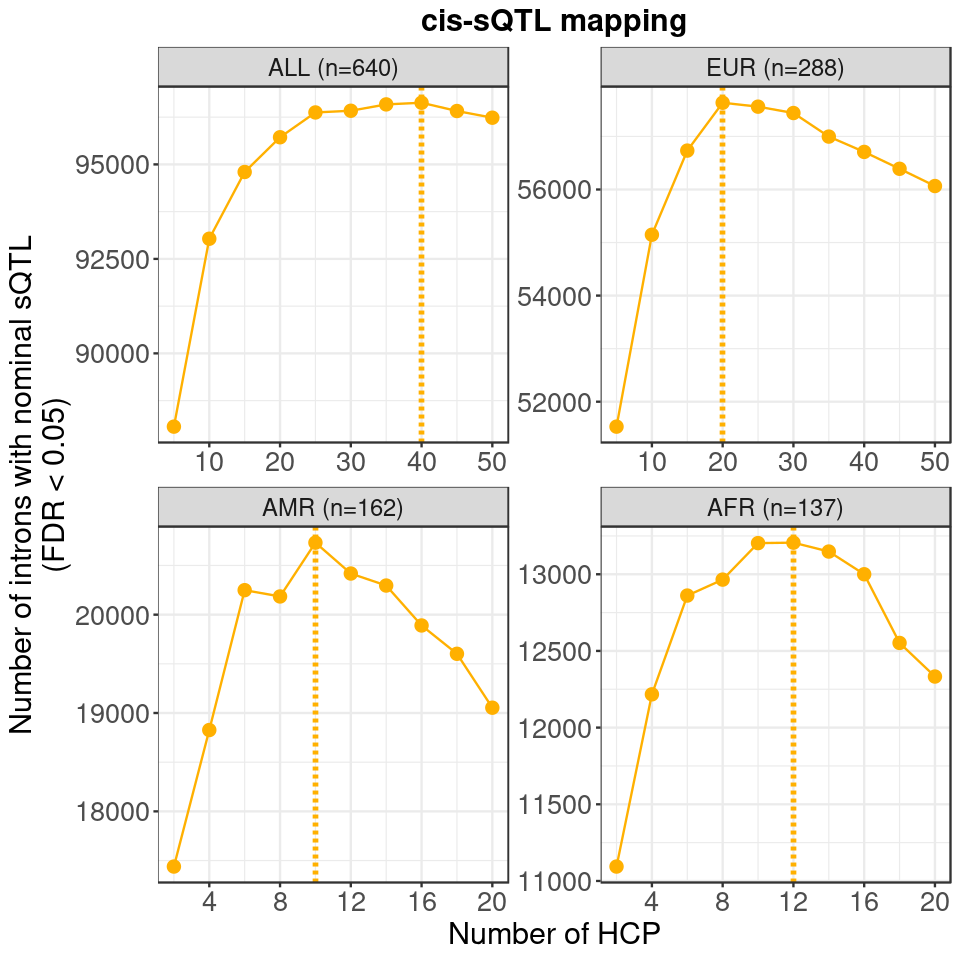

In [19]:
options(repr.plot.width = 8, repr.plot.height = 8)

all_seg <- data.frame(x = 40, y = 88062, xend = 40, yend = 96631, Population = "ALL (n=640)")
eur_seg <- data.frame(x = 20, y = 51530, xend = 20, yend = 57635, Population = "EUR (n=288)")
amr_seg <- data.frame(x = 10, y = 17439, xend = 10, yend = 20732, Population = "AMR (n=162)")
afr_seg <- data.frame(x = 12, y = 11094, xend = 12, yend = 13206, Population = "AFR (n=137)")

seg <- rbind(all_seg, eur_seg, amr_seg, afr_seg)
seg$Population <- factor(seg$Population, levels = c("ALL (n=640)", "EUR (n=288)", "AMR (n=162)", "AFR (n=137)"))

# can modify x ticks
breaks_fun <- function(x) {
  if (max(x) > 25) {
    seq(0, 55, 10)
  } else {
    seq(0, 22, 4)
  }
}



ggplot(df, aes(x = HCP, y = Count)) +
  geom_point(size = 3, color = "#FFB000") +
  geom_line(color = "#FFB000") +
  facet_wrap(~Population, scales = "free") +
#   geom_segment(data = seg, aes(x = x, y = y, xend = xend, yend = yend), 
#                linetype = "dashed", color = "#FFB000", size = 1.2) +
  labs(x = "Number of HCP", 
       y = "Number of introns with nominal sQTL\n(FDR < 0.05)", 
       title = "cis-sQTL mapping") +
  scale_x_continuous(breaks = breaks_fun) + 
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text.x = element_text(size = 14)) +
    geom_vline(data = seg, aes(xintercept = x), linetype = "dashed", size = 1.2, color = "#FFB000")

In [20]:
ggsave("figures/nominal.pdf", height = 8, width = 8)

### 2: Check batch effect
Used `--exclude-samples $related` in FastQTL.

In [4]:
rel <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)[,1]

In [5]:
walker <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

#### Combined

In [6]:
datExpr <- fread("cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

Warning message in fread("cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj_combat.tsv", :
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [4]:
dim(datExpr)

[1] 273167    654

In [7]:
datExpr <- datExpr %>% select(-all_of(rel))
dim(datExpr)

[1] 273167    640

In [8]:
datExpr_noCombat <- fread("cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat %>% select(-all_of(rel))
dim(datExpr_noCombat)

Warning message in fread("cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj.tsv", :
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    640

In [9]:
# leafcutter PC
pcs <- fread("cluster/leafcutter_perind.counts.nochr.gz.PCs", data.table = F)

In [10]:
rownames(pcs) <- pcs$id
pcs <- pcs[,-1]
head(pcs)

,Br2410.STARAligned.sortedByCoord.WASPfiltered.out.bam,1513.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1940.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1946.STARAligned.sortedByCoord.WASPfiltered.out.bam,Br1800.STARAligned.sortedByCoord.WASPfiltered.out.bam,11237.STARAligned.sortedByCoord.WASPfiltered.out.bam,18015.STARAligned.sortedByCoord.WASPfiltered.out.bam,11149.STARAligned.sortedByCoord.WASPfiltered.out.bam,1821.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1927.STARAligned.sortedByCoord.WASPfiltered.out.bam,...,11397.STARAligned.sortedByCoord.WASPfiltered.out.bam,11880.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1951.STARAligned.sortedByCoord.WASPfiltered.out.bam,15240.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1907.STARAligned.sortedByCoord.WASPfiltered.out.bam,1733.STARAligned.sortedByCoord.WASPfiltered.out.bam,11793.STARAligned.sortedByCoord.WASPfiltered.out.bam,11451.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1944.STARAligned.sortedByCoord.WASPfiltered.out.bam,1746.STARAligned.sortedByCoord.WASPfiltered.out.bam
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.017877653,-0.03776007,-0.0399438994,-0.034840027,0.039216661,0.042777407,0.00680397,0.040025498,-0.040061559,-0.03555976,...,0.04530387,0.059778879,-0.03954167,0.024260750,-0.04293632,-0.042537193,0.063484036,0.025710804,-0.033731566,-0.035502193
2,-0.027452747,-0.01357190,0.0002581652,-0.019766457,0.027710613,-0.050325371,0.05389210,-0.072974457,0.004356379,-0.02349720,...,-0.06266808,-0.032072332,-0.01300548,0.051624442,-0.01422004,-0.005643015,-0.030736006,-0.034915758,-0.027837885,-0.006428364
3,-0.065225429,0.02325125,0.0097687261,-0.012431315,-0.073467006,-0.002228612,0.06243331,-0.002567316,-0.028787573,0.01190221,...,0.02122932,-0.024992858,0.01291135,0.068553202,0.02339379,0.006006447,0.007709241,-0.049077223,0.001686122,0.003055421
4,-0.004633336,0.02774224,0.0240381892,0.039650198,0.051032396,-0.070285103,-0.06059388,-0.060115612,0.013812787,0.04095058,...,-0.04142289,-0.028879263,0.02230249,-0.055171281,0.03737948,0.017359515,-0.024020781,-0.033359065,0.036373508,0.025964255
5,-0.009158523,0.02910215,-0.0219780554,0.028450880,0.002987474,0.008799072,-0.01515512,0.025253912,-0.014393287,0.01796297,...,0.05543516,-0.055322036,-0.07368691,-0.007631145,-0.03650489,-0.033830322,-0.017014639,-0.001806438,0.025002470,-0.084750434
6,-0.074177559,0.04091055,-0.0292489468,0.001017282,-0.046841223,0.023123895,0.02886275,0.005371299,0.021059925,0.02115725,...,0.03097390,-0.002297913,-0.03509165,0.016848183,-0.03355458,0.040141142,0.033118419,-0.042348883,0.011492217,0.020540929


In [10]:
dim(pcs)

[1]  50 654

In [11]:
subj <- colnames(pcs)
for(i in 1:length(subj)){
    subj[i] <- strsplit(subj[i],"[.]")[[1]][1]
}
index <- which(colnames(pcs)=="1707.1.STARAligned.sortedByCoord.out.bam")
subj[index] <- "1707.1"
colnames(pcs) <- subj

In [12]:
head(pcs)

,Br2410,1513,RNAID1940,RNAID1946,Br1800,11237,18015,11149,1821,RNAID1927,⋯,11397,11880,RNAID1951,15240,RNAID1907,1733,11793,11451,RNAID1944,1746
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.017877653,-0.03776007,-0.0399438994,-0.034840027,0.039216661,0.042777407,0.00680397,0.040025498,-0.040061559,-0.03555976,⋯,0.04530387,0.059778879,-0.03954167,0.024260750,-0.04293632,-0.042537193,0.063484036,0.025710804,-0.033731566,-0.035502193
2,-0.027452747,-0.01357190,0.0002581652,-0.019766457,0.027710613,-0.050325371,0.05389210,-0.072974457,0.004356379,-0.02349720,⋯,-0.06266808,-0.032072332,-0.01300548,0.051624442,-0.01422004,-0.005643015,-0.030736006,-0.034915758,-0.027837885,-0.006428364
3,-0.065225429,0.02325125,0.0097687261,-0.012431315,-0.073467006,-0.002228612,0.06243331,-0.002567316,-0.028787573,0.01190221,⋯,0.02122932,-0.024992858,0.01291135,0.068553202,0.02339379,0.006006447,0.007709241,-0.049077223,0.001686122,0.003055421
4,-0.004633336,0.02774224,0.0240381892,0.039650198,0.051032396,-0.070285103,-0.06059388,-0.060115612,0.013812787,0.04095058,⋯,-0.04142289,-0.028879263,0.02230249,-0.055171281,0.03737948,0.017359515,-0.024020781,-0.033359065,0.036373508,0.025964255
5,-0.009158523,0.02910215,-0.0219780554,0.028450880,0.002987474,0.008799072,-0.01515512,0.025253912,-0.014393287,0.01796297,⋯,0.05543516,-0.055322036,-0.07368691,-0.007631145,-0.03650489,-0.033830322,-0.017014639,-0.001806438,0.025002470,-0.084750434
6,-0.074177559,0.04091055,-0.0292489468,0.001017282,-0.046841223,0.023123895,0.02886275,0.005371299,0.021059925,0.02115725,⋯,0.03097390,-0.002297913,-0.03509165,0.016848183,-0.03355458,0.040141142,0.033118419,-0.042348883,0.011492217,0.020540929


In [12]:
# pcs <- pcs %>% select(-all_of(rel))
# dim(pcs)
sum(colnames(pcs) %in% rel)
pcs <- pcs[,!names(pcs) %in% rel]
dim(pcs)

[1] 14

[1]  50 640

In [13]:
cov <- read.table("data/40hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)
head(cov)

[1]  47 654

,Br2410,1513,RNAID1940,RNAID1946,Br1800,11237,18015,11149,1821,RNAID1927,...,11397,11880,RNAID1951,15240,RNAID1907,1733,11793,11451,RNAID1944,1746
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PC1,0.0134498,0.00883737,0.0105646,-0.0100042,-0.0264156,0.00964951,-0.0305498,0.009554,0.0125086,0.00967876,...,0.00699529,0.00927248,0.0100571,0.0126193,-0.022778,0.0109438,0.00721341,0.00797005,0.0108942,-0.00792391
PC2,-0.0261084,-0.00241496,0.0112017,0.0129359,-0.00285026,-0.0204621,-0.00136264,-0.0212812,-0.0213104,0.0282592,...,-0.0165036,-0.0199631,0.00285186,-0.0222361,-0.00425556,-0.0140367,-0.00334149,-0.0197482,-0.0146632,-0.0111467
PC3,-0.00626668,-0.021557,-0.00268095,-4.52633e-05,-0.00101463,-0.00514834,-0.000380779,-0.00498539,-0.00520913,-0.00130432,...,0.00345509,-0.0035407,-0.0286316,-0.00414057,-0.00136336,-0.0110339,0.0224404,-0.00454864,-0.0107195,-0.00225043
PC4,0.0144448,-0.0266302,0.0116105,0.00637793,0.00137324,0.0214545,0.00128887,0.0227153,0.0104166,0.0125259,...,0.0174746,0.0220455,-0.0386816,0.0128115,0.000375508,-0.00457751,0.00286154,0.0225033,-0.00350128,0.00555587
PC5,-0.0153651,-0.00174134,-0.00695816,-0.00397614,-0.00378136,0.0668738,-0.0017333,0.0678296,-0.0156755,-0.00241945,...,0.0709577,0.0691673,0.00281472,-0.0166991,-0.00515377,-0.0107143,0.0806309,0.06695,-0.00934632,-0.00967133
sex,M,M,M,F,M,M,F,F,F,F,...,F,M,F,F,M,F,M,M,F,M


In [14]:
cov <- cov[,!names(cov) %in% rel]
dim(cov)

[1]  47 640

In [15]:
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

In [16]:
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [17]:
pcs <- t(pcs)
pcs <- cbind(1, pcs)
storage.mode(pcs) <- "numeric"

Y <- as.matrix(datExpr_noCombat)
X <- as.matrix(pcs)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed_pcs <- Y - t(X[,-1]  %*% beta[-1,])

In [18]:
groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [19]:
# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

In [20]:
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

In [21]:
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

In [22]:
# regressed by leafcutter PCs
s_3 <- svd(datExpr_regressed_pcs - rowMeans(datExpr_regressed_pcs))
PC1_3 <- s_3$d[1]*s_3$v[,1]
PC2_3 <- s_3$d[2]*s_3$v[,2]
data3 <- data.frame(PC1_3, PC2_3, "Data" = groups_fac)

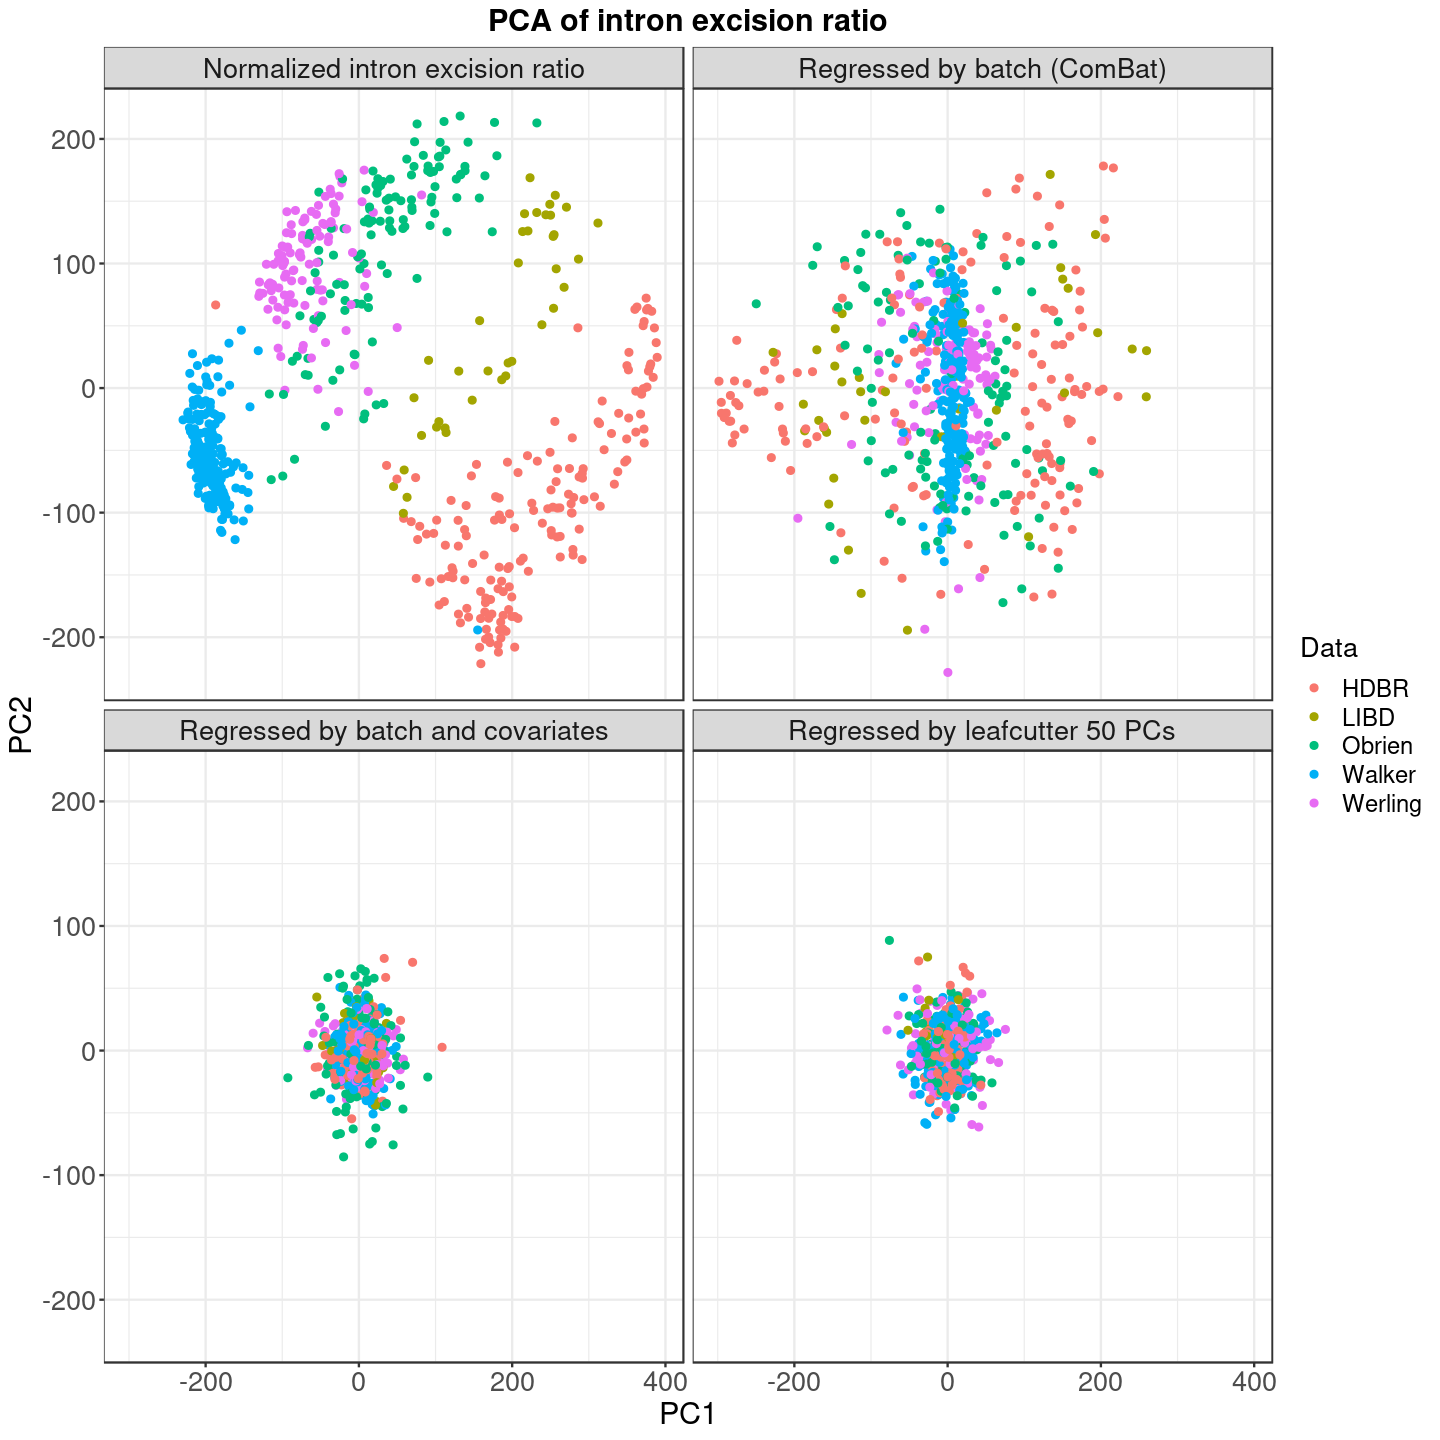

In [24]:
options(repr.plot.width = 12, repr.plot.height = 12)

colnames(data1) <- colnames(data2) <- colnames(data3) <- c("PC1", "PC2", "Data")
data4 <- rbind(data, data1, data2, data3)

data4$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]),
                 rep("Regressed by leafcutter 50 PCs", dim(data3)[1]))
ggplot(data4, aes(x = PC1, y = PC2, color = Data)) +
  geom_point() +
  facet_wrap(~group, scales = "fixed") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text = element_text(size = 16),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14))

In [25]:
ggsave("figures/pc.pdf", height = 12, width = 12)

In [26]:
colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_all <- rbind(data, data1, data2)

data3_all$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))

**Figure out what's going on with Walker data. Try regressing without HCPs**

In [26]:
cov_no_hidden <- cov[,!substring(colnames(cov), 1, 3) == "HCP"]
head(cov_no_hidden)
dim(cov_no_hidden)

,,PC1,PC2,PC3,PC4,PC5,sex,age
Br2410,1,0.01344980,-0.02610840,-6.26668e-03,0.01444480,-0.01536510,1,-0.5178080
1513,1,0.00883737,-0.00241496,-2.15570e-02,-0.02663020,-0.00174134,1,-0.4602740
RNAID1940,1,0.01056460,0.01120170,-2.68095e-03,0.01161050,-0.00695816,1,-0.3835616
RNAID1946,1,-0.01000420,0.01293590,-4.52633e-05,0.00637793,-0.00397614,0,-0.4602740
Br1800,1,-0.02641560,-0.00285026,-1.01463e-03,0.00137324,-0.00378136,1,-0.4219180
11237,1,0.00964951,-0.02046210,-5.14834e-03,0.02145450,0.06687380,1,-0.6136986


[1] 640   8

In [28]:
Y <- as.matrix(datExpr)
X <- as.matrix(cov_no_hidden)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed_no_hidden <- Y - t(X[,-1]  %*% beta[-1,])

s <- svd(datExpr_regressed_no_hidden - rowMeans(datExpr_regressed_no_hidden))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

In [29]:
head(data)
dim(data)

,PC1,PC2,Data
,<dbl>,<dbl>,<fct>
1,259.6087805,40.160483,LIBD
2,2.5912779,-34.849309,Walker
3,-24.2526893,2.712115,Walker
4,7.6058195,-67.600885,Walker
5,0.3199109,-2.843020,LIBD
6,114.9469272,75.729158,HDBR


[1] 640   3

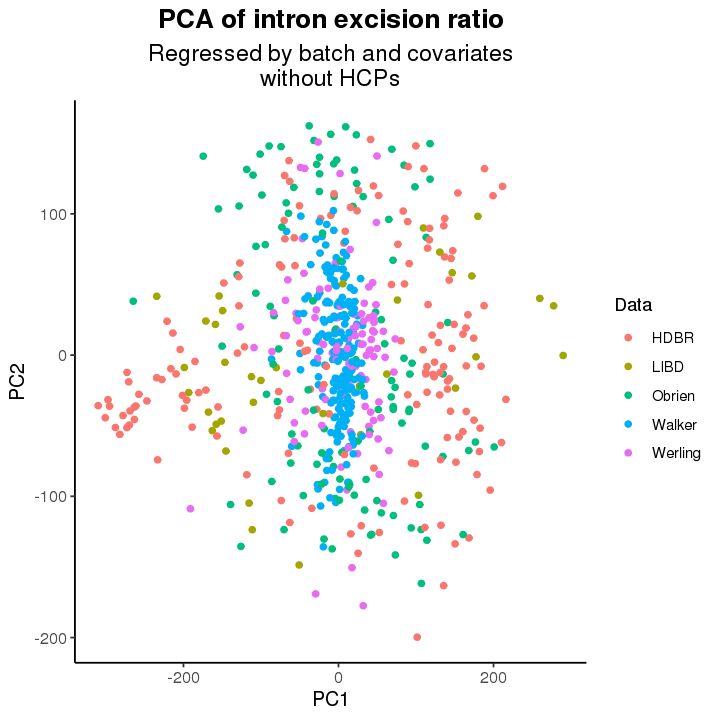

In [30]:
options(repr.plot.width=6, repr.plot.height=6)

p <- ggplot(data, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of intron excision ratio",
       subtitle = "Regressed by batch and covariates\nwithout HCPs") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p

#### EUR

In [27]:
datExpr <- fread("data/eur/lc_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
dim(datExpr)
datExpr <- datExpr[,!names(datExpr)%in%rel]
dim(datExpr)

Warning message in fread("data/eur/lc_combat.tsv", data.table = F):
“Detected 292 column names but the data has 293 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    292

[1] 273167    288

In [28]:
datExpr_noCombat <- fread("data/eur/lc.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat)%in%rel]
dim(datExpr_noCombat)

Warning message in fread("data/eur/lc.tsv", data.table = F):
“Detected 292 column names but the data has 293 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    288

In [29]:
cov <- read.table("data/eur/20HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)

cov <- cov[,!names(cov)%in%rel]
dim(cov)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

[1]  27 292

[1]  27 288

In [30]:
Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [31]:
groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [32]:
# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

In [33]:
colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_eur <- rbind(data, data1, data2)

data3_eur$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))

#### AMR

In [34]:
datExpr <- fread("data/amr/lc_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
dim(datExpr)
datExpr <- datExpr[,!names(datExpr)%in%rel]
dim(datExpr)

datExpr_noCombat <- fread("data/amr/lc.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat)%in%rel]
dim(datExpr_noCombat)

cov <- read.table("data/amr/10HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)

cov <- cov[,!names(cov)%in%rel]
dim(cov)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_amr <- rbind(data, data1, data2)

data3_amr$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))

Warning message in fread("data/amr/lc_combat.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    164

[1] 273167    162

Warning message in fread("data/amr/lc.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    162

[1]  17 164

[1]  17 162

#### AFR

In [35]:
datExpr <- fread("data/afr/lc_combat.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
dim(datExpr)
datExpr <- datExpr[,!names(datExpr)%in%rel]
dim(datExpr)

datExpr_noCombat <- fread("data/afr/lc.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat)%in%rel]
dim(datExpr_noCombat)

cov <- read.table("data/afr/12HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]
dim(cov)

cov <- cov[,!names(cov)%in%rel]
dim(cov)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
# regressed by covariates
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3_afr <- rbind(data, data1, data2)

data3_afr$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized intron excision ratio", dim(data2)[1]))

Warning message in fread("data/afr/lc_combat.tsv", data.table = F):
“Detected 145 column names but the data has 146 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    145

[1] 273167    137

Warning message in fread("data/afr/lc.tsv", data.table = F):
“Detected 145 column names but the data has 146 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 273167    137

[1]  19 145

[1]  19 137

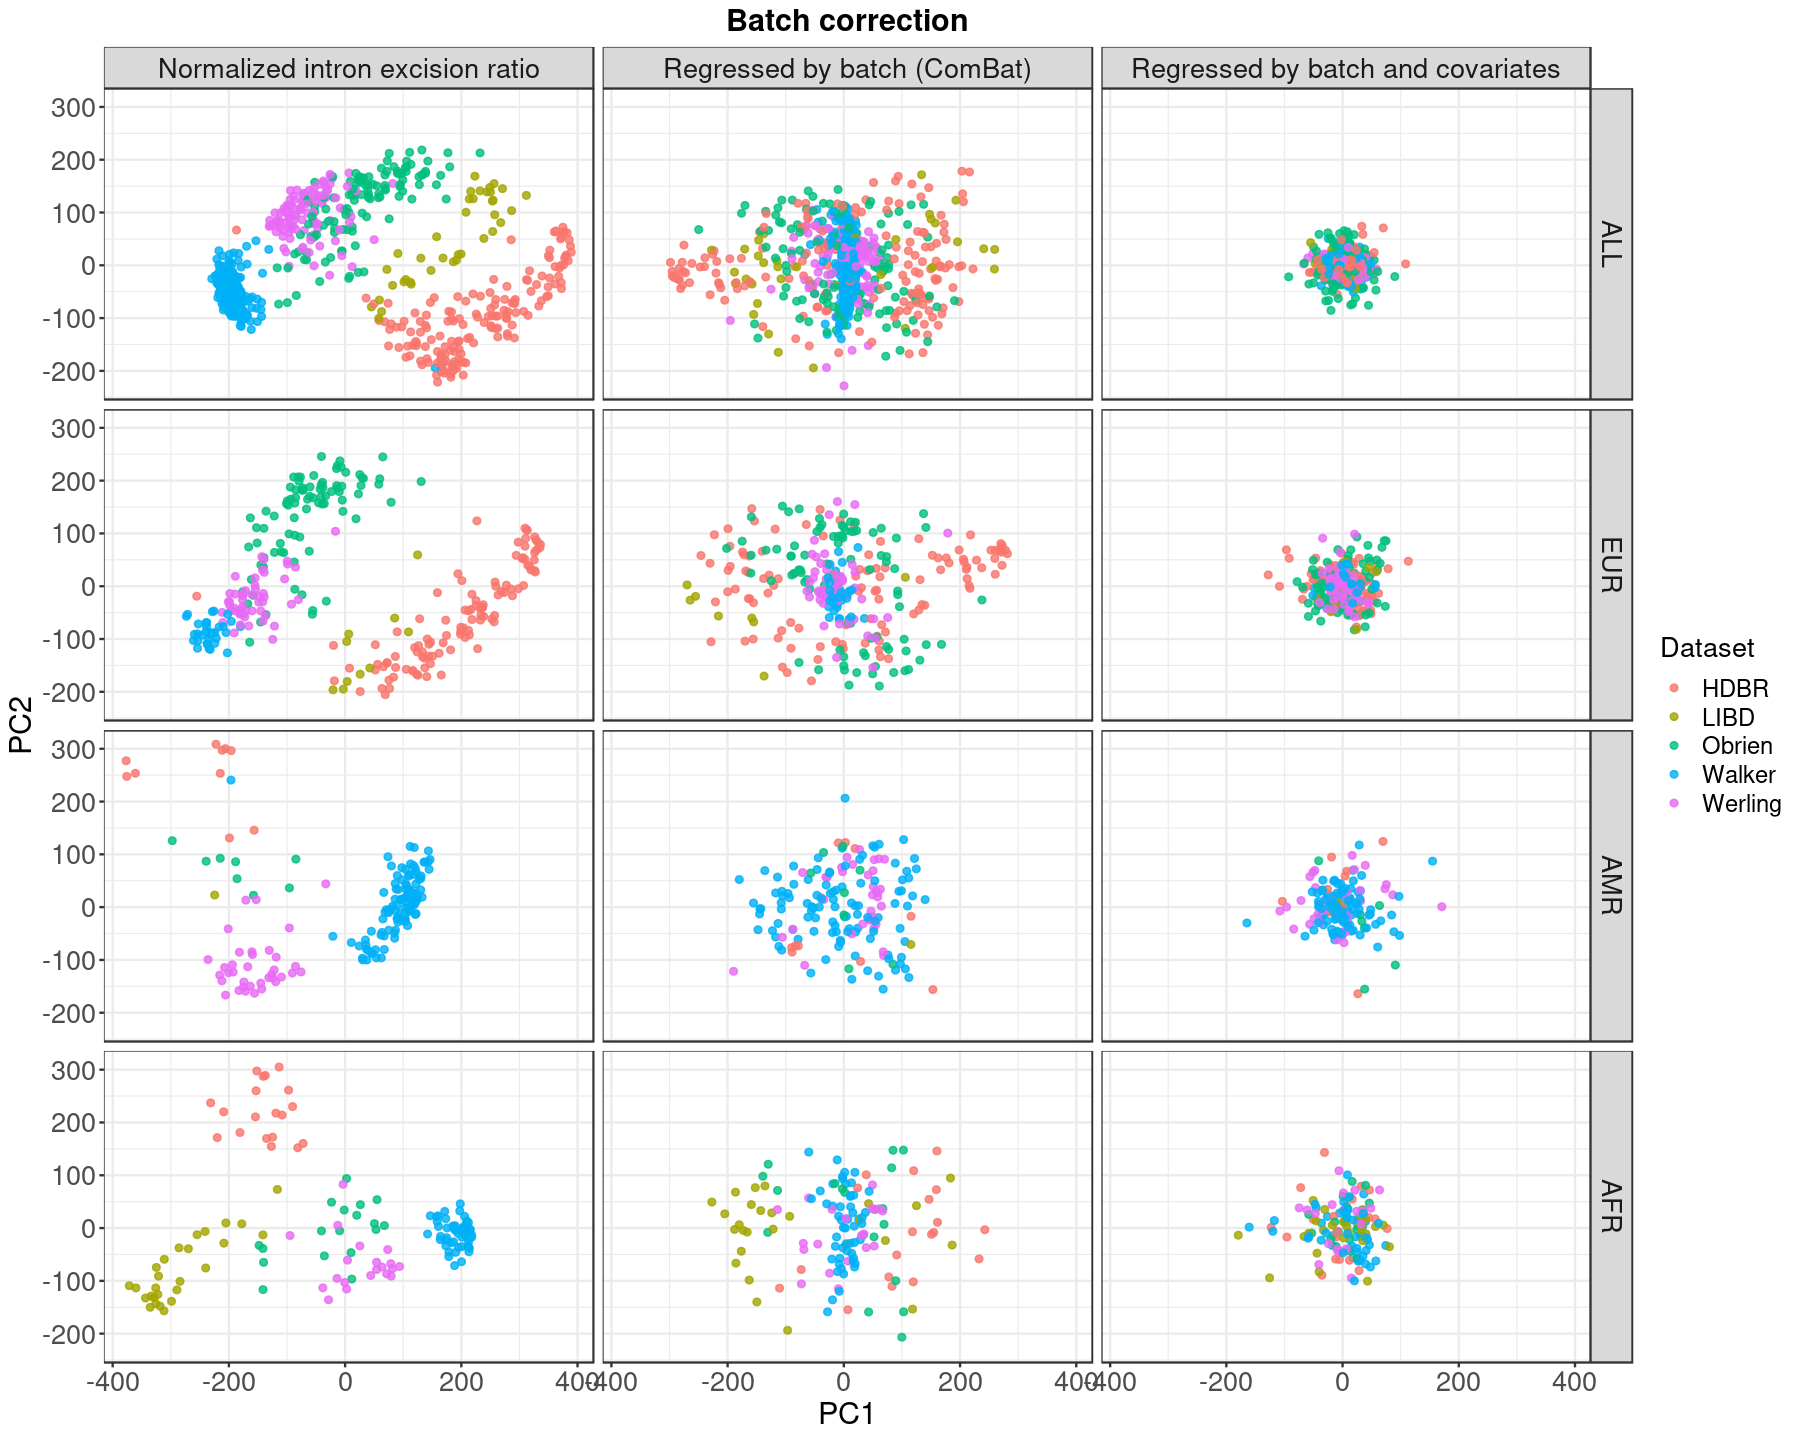

In [36]:
df <- rbind(data3_all, data3_eur, data3_amr, data3_afr)
df$Population <- c(rep("ALL", 640*3), 
                   rep("EUR", 288*3), 
                   rep("AMR", 162*3), 
                   rep("AFR", 137*3))
df$Population <- factor(df$Population, 
                        levels = c("ALL", "EUR", "AMR", "AFR"))

colnames(df)[3] <- "Dataset"

options(repr.plot.height = 12, repr.plot.width = 15)

ggplot(df, aes(x = PC1, y = PC2, color = Dataset)) +
  geom_point(alpha = 0.8) +
  facet_grid(Population ~ group, scales = "fixed") +
  labs(x = "PC1", y = "PC2", 
       title = "Batch correction") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text = element_text(size = 16),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14))

ggsave("figures/regress.pdf", width = 15, height = 12)

### 3: beta-approximated permutation pvalue

In [37]:
mixed <- fread("results/mixed_perm_40hcp_1e6/all.chunks.txt.gz", data.table = F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
mixed <- mixed[complete.cases(mixed),]
mixed <- arrange(mixed, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()

In [39]:
eur <- fread("results/eur_perm_20HCP_1e6/all.chunks.txt.gz", data.table = F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
eur <- eur[complete.cases(eur),]
eur <- arrange(eur, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()

In [40]:
amr <- fread("results/amr_perm_10HCP_1e6/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
amr <- amr[complete.cases(amr),]
amr <- arrange(amr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()

In [41]:
afr <- fread("results/afr_perm_12HCP_1e6/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
afr <- afr[complete.cases(afr),]
afr <- arrange(afr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()

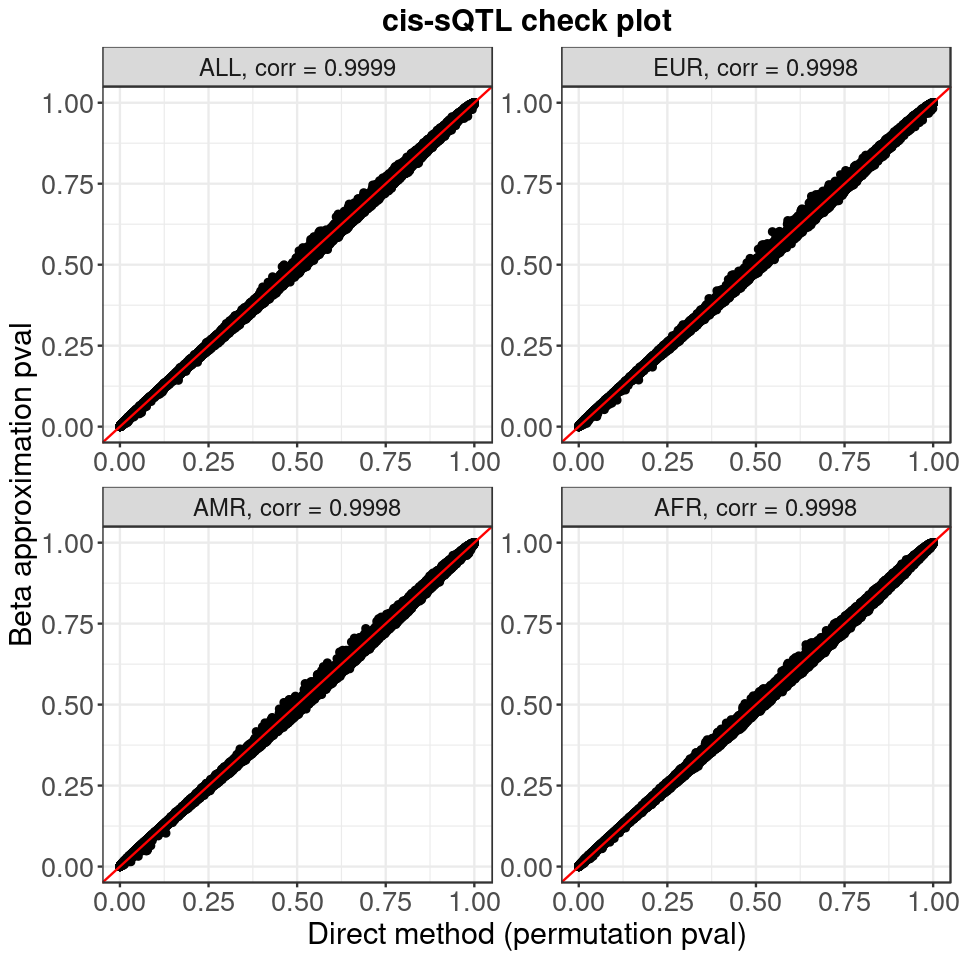

In [42]:
df <- rbind(mixed, eur, amr, afr)
df$Population <- c(rep("ALL, corr = 0.9999", nrow(mixed)), 
                   rep("EUR, corr = 0.9998", nrow(eur)), 
                   rep("AMR, corr = 0.9998", nrow(amr)),
                   rep("AFR, corr = 0.9998", nrow(afr)))
df$Population <- factor(df$Population, levels = c("ALL, corr = 0.9999", 
                                                  "EUR, corr = 0.9998", 
                                                  "AMR, corr = 0.9998", 
                                                  "AFR, corr = 0.9998"))

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(df, aes(x = ppval, y = bpval)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, color = "red") +
  facet_wrap(~Population, scales = "free") +
  labs(x = "Direct method (permutation pval)", 
       y = "Beta approximation pval", 
       title = "cis-sQTL check plot") +
#   scale_x_continuous(breaks = breaks_fun) + 
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        strip.text.x = element_text(size = 14))

ggsave("figures/check.pdf", height = 8, width = 8)

### 4: top sQTL distance to intron splice junction

In [43]:
mixed_sig <- read.table("results/mixed_perm_40hcp_1e6/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc <- fread("results/mixed_perm_40hcp_1e6/all_assoc.txt.gz", data.table = F)

eur_sig <- read.table("results/eur_perm_20HCP_1e6/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_eur <- fread("results/eur_perm_20HCP_1e6/all_assoc.txt.gz", data.table = F)

amr_sig <- read.table("results/amr_perm_10HCP_1e6/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_amr <- fread("results/amr_perm_10HCP_1e6/all_assoc.txt.gz", data.table = F)

afr_sig <- read.table("results/afr_perm_12HCP_1e6/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_afr <- fread("results/afr_perm_12HCP_1e6/all_assoc.txt.gz", data.table = F)

In [44]:
all_assoc <- all_assoc %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
all_assoc$sig <- as.factor(all_assoc$sig)
all_assoc <- all_assoc %>% mutate(dist_kb = dist/1000)

all_assoc_eur <- all_assoc_eur %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
all_assoc_eur <- all_assoc_eur %>% mutate(dist_kb = dist/1000)
all_assoc_eur$sig <- as.factor(all_assoc_eur$sig)

all_assoc_amr <- all_assoc_amr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
all_assoc_amr <- all_assoc_amr %>% mutate(dist_kb = dist/1000)
all_assoc_amr$sig <- as.factor(all_assoc_amr$sig)

all_assoc_afr <- all_assoc_afr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
all_assoc_afr <- all_assoc_afr %>% mutate(dist_kb = dist/1000)
all_assoc_afr$sig <- as.factor(all_assoc_afr$sig)

In [45]:
df <- rbind(all_assoc, all_assoc_eur, all_assoc_amr, all_assoc_afr)
df$Population <- c(rep("ALL", nrow(all_assoc)),
                   rep("EUR", nrow(all_assoc_eur)), 
                   rep("AMR", nrow(all_assoc_amr)), 
                   rep("AFR", nrow(all_assoc_afr)))
df$Population <- factor(df$Population, levels = c("ALL", "EUR", "AMR", "AFR"))

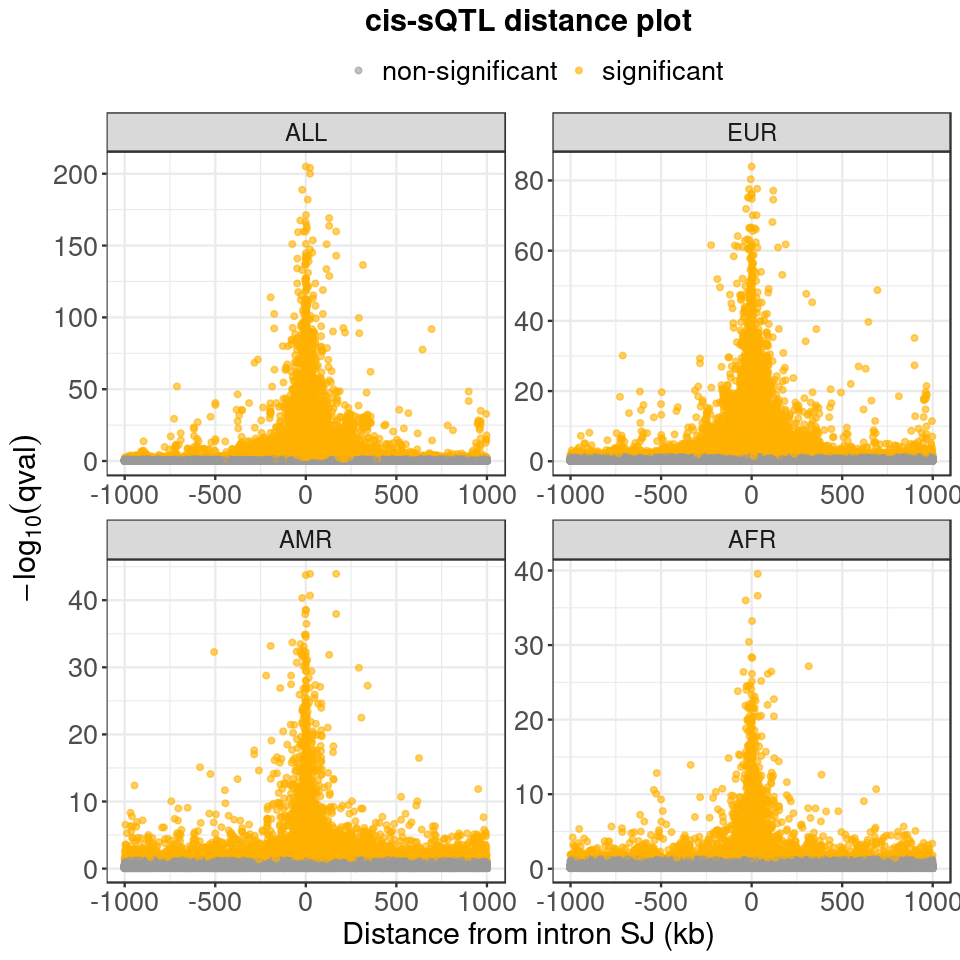

In [46]:
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(df, aes(x = dist_kb)) +
    geom_point(aes(y = -log10(qval), color = sig), alpha = .6, size = 1.2) +
    facet_wrap (~Population, scales = "free") +
    labs(x = "Distance from intron SJ (kb)",
         y = expression(-log[10](qval)),
         title = "cis-sQTL distance plot",
         color = "") +
    theme_bw() +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.text = element_text(size = 16),
         legend.position = "top",
         strip.text.x = element_text(size = 14)) +
    scale_color_manual(values=c("#999999", "#FFB000")) 

In [47]:
ggsave("figures/dist.pdf", height = 8, width = 8)

### 5: Map introns to genes; identify sGene

### 5-1: The GTEx way. See Snakefile rule `map_clusters_to_genes`
- Idea: for each intron, match it to exons by 3' or 5' position; then map intron clusters to all the genes that introns in this cluster can map to; one cluster can map to multiple genes
- In this way 71,429 out of 105,700 clusters mapped to some genes; 5,132 clusters mapped to more than 1 gene

In [48]:
exons_table <- fread("leafviz_annot/gencode_v33lift37_all_exons.txt.gz", data.table = F)
dim(exons_table)
head(exons_table)

[1] 1379814       5

,chr,start,end,strand,gene_name
,<chr>,<int>,<int>,<chr>,<chr>
1,chr17,40475053,40475643,-,STAT3
2,chr17,40476729,40476864,-,STAT3
3,chr17,40476981,40477079,-,STAT3
4,chr2,105049895,105050981,+,LINC01102
5,chr2,105122324,105122761,+,LINC01102
6,chr2,105123690,105123864,+,LINC01102


In [49]:
intron_counts <- fread("cluster/leafcutter_perind.counts.gz", data.table = F)

In [42]:
dim(intron_counts)
head(intron_counts)

[1] 502571    655

,chrom,Br2410.STARAligned.sortedByCoord.WASPfiltered.out.bam,1513.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1940.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1946.STARAligned.sortedByCoord.WASPfiltered.out.bam,Br1800.STARAligned.sortedByCoord.WASPfiltered.out.bam,11237.STARAligned.sortedByCoord.WASPfiltered.out.bam,18015.STARAligned.sortedByCoord.WASPfiltered.out.bam,11149.STARAligned.sortedByCoord.WASPfiltered.out.bam,1821.STARAligned.sortedByCoord.WASPfiltered.out.bam,⋯,11397.STARAligned.sortedByCoord.WASPfiltered.out.bam,11880.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1951.STARAligned.sortedByCoord.WASPfiltered.out.bam,15240.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1907.STARAligned.sortedByCoord.WASPfiltered.out.bam,1733.STARAligned.sortedByCoord.WASPfiltered.out.bam,11793.STARAligned.sortedByCoord.WASPfiltered.out.bam,11451.STARAligned.sortedByCoord.WASPfiltered.out.bam,RNAID1944.STARAligned.sortedByCoord.WASPfiltered.out.bam,1746.STARAligned.sortedByCoord.WASPfiltered.out.bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr2:28307:31216:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
2,chr2:28307:31857:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
3,chr2:28307:45490:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
4,chr2:28307:50703:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,1/1,0/0,0/0,0/0
5,chr2:28307:81451:clu_1_NA,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0,0/0,0/0
6,chr2:37649:37743:clu_2_NA,0/0,0/0,1/1,0/0,0/0,0/0,0/0,0/0,0/0,⋯,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


In [43]:
introns <- intron_counts$chrom
intron_meta <- do.call(rbind, strsplit(introns,":"))
colnames(intron_meta) <- c("chr","start","end","clu")
intron_meta <- as.data.frame(intron_meta, stringsAsFactors=FALSE)
intron_meta$start <- as.numeric(intron_meta$start)
intron_meta$end <- as.numeric(intron_meta$end)

head(intron_meta)

,chr,start,end,clu
,<chr>,<dbl>,<dbl>,<chr>
1,chr2,28307,31216,clu_1_NA
2,chr2,28307,31857,clu_1_NA
3,chr2,28307,45490,clu_1_NA
4,chr2,28307,50703,clu_1_NA
5,chr2,28307,81451,clu_1_NA
6,chr2,37649,37743,clu_2_NA


In [47]:
chr <- "chr22"

In [48]:
intron_chr <- intron_meta[ intron_meta$chr==chr, ]
dim(intron_chr)
exons_chr <- exons_table[exons_table$chr==chr, ]
dim(exons_chr)

[1] 11777     4

[1] 29775     5

In [49]:
exons_chr$temp <- exons_chr$start
intron_chr$temp <- intron_chr$end
three_prime_matches <- inner_join( intron_chr, exons_chr, by="temp")

exons_chr$temp <- exons_chr$end
intron_chr$temp <- intron_chr$start
five_prime_matches <- inner_join( intron_chr, exons_chr, by="temp")

In [50]:
head(three_prime_matches)
dim(three_prime_matches)

,chr.x,start.x,end.x,clu,temp,chr.y,start.y,end.y,strand,gene_name
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
1,chr22,16189378,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
2,chr22,16189378,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
3,chr22,16189378,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
4,chr22,16189411,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
5,chr22,16189411,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9
6,chr22,16189411,16190681,clu_25302_NA,16190681,chr22,16190681,16190791,-,AP000525.9


[1] 28379    10

In [51]:
all_matches <- rbind(three_prime_matches, five_prime_matches)[ , c("clu", "gene_name")]

In [52]:
dim(all_matches)

[1] 57335     2

In [53]:
all_matches <- all_matches[!duplicated(all_matches),]
dim(all_matches)

[1] 1832    2

In [54]:
length(unique(all_matches$clu))

[1] 1625

In [2]:
res <- fread("leafviz_annot/leafcutter_clusters_to_genes.txt", data.table = F)

In [3]:
head(res)

,clu,genes
,<chr>,<chr>
1,chr1:clu_10000_NA,BSDC1
2,chr1:clu_10001_NA,FAM167B
3,chr1:clu_10003_NA,MTMR9LP
4,chr1:clu_10004_NA,LCK
5,chr1:clu_10005_NA,LCK
6,chr1:clu_10006_NA,LCK


In [4]:
dim(res)
length(unique(res$clu))

[1] 71429     2

[1] 71429

In [5]:
sum(grepl(",", res$genes))

[1] 5132

In [6]:
head(res[grepl(",", res$genes),])

,clu,genes
,<chr>,<chr>
18,chr1:clu_10032_NA,"AL033529.1,ZBTB8B"
19,chr1:clu_10034_NA,"ZBTB8A,AL033529.1"
60,chr1:clu_10110_NA,"PHC2,A3GALT2"
106,chr1:clu_10166_NA,"SMIM12,AL121988.1"
111,chr1:clu_10173_NA,"TMEM35B,AC114490.3,AC114490.2,ZMYM6"
112,chr1:clu_10174_NA,"ZMYM6,AC114490.2"


### 5-2: Leafviz way
See Snakefile rule `annotate_intron` and `summarise_annot`.

In [54]:
load("leafviz_annot/leafviz.RData")

In [56]:
length(classification.list)
length(constitutive.list)
length(coord.list)
length(ensemblID.list)
length(unlist(ensemblID.list))
length(gene.list)
length(unlist(gene.list))
length(transcripts.list)
length(unlist(transcripts.list))
length(verdict.list)
length(unlist(verdict.list))

[1] 105700

[1] 105700

[1] 105700

[1] 105700

[1] 502571

[1] 105700

[1] 502571

[1] 105700

[1] 502571

[1] 105700

[1] 502571

In [57]:
load("leafviz_annot/all.introns.RData")

In [10]:
head(all.introns)

,chr,start,end,clusterID,verdict,gene,ensemblID,transcripts,constitutive.score
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,chr2,28307,31216,clu_1_NA,unknown_strand,.,.,NA,1
2,chr2,28307,31857,clu_1_NA,unknown_strand,.,.,NA,1
3,chr2,28307,45490,clu_1_NA,unknown_strand,.,.,NA,1
4,chr2,28307,50703,clu_1_NA,unknown_strand,.,.,NA,1
5,chr2,28307,81451,clu_1_NA,unknown_strand,.,.,NA,1
6,chr2,37649,37743,clu_2_NA,unknown_strand,.,.,NA,1


In [58]:
dim(all.introns)
length(unique(all.introns$gene))
length(unique(all.introns$ensemblID))

[1] 502571      9

[1] 22743

[1] 22751

**Any genes with more than 1 ensemblID?**

Yes. Very few. See below for an example. `C2orf27A` has two ensemblID in gencode annotation. `annotate_intron.R` will match the intron cluster to the ensemblID it matches. 

In [13]:
df <- data.frame("gene" = unique(all.introns$gene),
                 "gene_id" = NA)

In [54]:
# for (i in 1:nrow(df)) {
#     df[i,2] <- c(unique(all.introns %>% filter(gene == df[i,1]) %>% select(ensemblID))$ensemblID)
# }

In [21]:
all.introns %>% filter(ensemblID %in% c("ENSG00000287151.1_1", "ENSG00000197927.13_7"))

chr,start,end,clusterID,verdict,gene,ensemblID,transcripts,constitutive.score
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
chr2,132440130,132442282,clu_4259_NA,annotated,C2orf27A,ENSG00000287151.1_1,ENST00000657415.1_1+ENST00000666411.1_1,0.67
chr2,132440172,132442282,clu_4259_NA,annotated,C2orf27A,ENSG00000287151.1_1,ENST00000653458.1_1,0.33
chr2,132440561,132442282,clu_4259_NA,cryptic_fiveprime,C2orf27A,ENSG00000287151.1_1,.,0.00
chr2,132441427,132442282,clu_4259_NA,cryptic_fiveprime,C2orf27A,ENSG00000287151.1_1,.,0.00
chr2,132442346,132443637,clu_4260_NA,cryptic_fiveprime,C2orf27A,ENSG00000287151.1_1,.,0.00
chr2,132442392,132443637,clu_4260_NA,annotated,C2orf27A,ENSG00000287151.1_1,ENST00000652878.1_1+ENST00000657415.1_1+ENST00000666411.1_1,0.60
chr2,132442392,132443670,clu_4260_NA,annotated,C2orf27A,ENSG00000287151.1_1,ENST00000653458.1_1,0.20
chr2,132442392,132443903,clu_4260_NA,novel annotated pair,C2orf27A,ENSG00000287151.1_1,ENST00000652878.1_1+ENST00000653458.1_1+ENST00000657415.1_1+ENST00000666411.1_1,0.80
chr2,132443784,132443903,clu_4260_NA,annotated,C2orf27A,ENSG00000287151.1_1,ENST00000652878.1_1+ENST00000653458.1_1+ENST00000655714.1_1+ENST00000657415.1_1+ENST00000666411.1_1,1.00


**How many genes tested for sQTL?**

In [59]:
pheno <- fread("cluster/leafcutter_perind.counts.nochr.gz.qqnorm_all_fixSubj_combat.bed.gz", data.table = F)

In [60]:
dim(pheno)

[1] 273167    658

In [61]:
pheno <- pheno %>% select(ID)

In [62]:
all.introns <- all.introns %>% unite("ID", chr:start:end:clusterID, na.rm = FALSE, remove = TRUE, sep = ":")
head(all.introns)

Warning message in x:y:
“numerical expression has 2 elements: only the first used”
Warning message in x:y:
“numerical expression has 3 elements: only the first used”


,ID,verdict,gene,ensemblID,transcripts,constitutive.score
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,chr2:28307:31216:clu_1_NA,unknown_strand,.,.,NA,1
2,chr2:28307:31857:clu_1_NA,unknown_strand,.,.,NA,1
3,chr2:28307:45490:clu_1_NA,unknown_strand,.,.,NA,1
4,chr2:28307:50703:clu_1_NA,unknown_strand,.,.,NA,1
5,chr2:28307:81451:clu_1_NA,unknown_strand,.,.,NA,1
6,chr2:37649:37743:clu_2_NA,unknown_strand,.,.,NA,1


In [63]:
all.introns$ID <- gsub("chr", "", all.introns$ID)
head(all.introns)

,ID,verdict,gene,ensemblID,transcripts,constitutive.score
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,2:28307:31216:clu_1_NA,unknown_strand,.,.,NA,1
2,2:28307:31857:clu_1_NA,unknown_strand,.,.,NA,1
3,2:28307:45490:clu_1_NA,unknown_strand,.,.,NA,1
4,2:28307:50703:clu_1_NA,unknown_strand,.,.,NA,1
5,2:28307:81451:clu_1_NA,unknown_strand,.,.,NA,1
6,2:37649:37743:clu_2_NA,unknown_strand,.,.,NA,1


In [64]:
pheno <- pheno %>% left_join(all.introns, by = "ID")
head(pheno)

,ID,verdict,gene,ensemblID,transcripts,constitutive.score
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1:14829:14930:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
2,1:14829:14970:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
3,1:14829:15021:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
4,1:14829:15796:clu_7637_NA,cryptic_threeprime,WASH7P,ENSG00000227232.5_3,.,0.0
5,1:15038:15796:clu_7637_NA,annotated,WASH7P,ENSG00000227232.5_3,ENST00000488147.1_2,0.5
6,1:15942:16607:clu_7638_NA,cryptic_threeprime,WASH7P,ENSG00000227232.5_3,.,0.0


In [65]:
dim(pheno)
length(unique(pheno$ID))
length(unique(pheno$gene))
length(unique(pheno$ensemblID))

[1] 273167      6

[1] 273167

[1] 14362

[1] 14368

In [45]:
save(pheno, file = "leafviz_annot/all.introns.tested.RData")

### 5-3: sGene

In [50]:
load("leafviz_annot/all.introns.tested.RData")

In [52]:
head(all_assoc)
head(pheno)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,sig,dist_kb
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,1:10002840:10003307:clu_8527_NA,6073,1.029930,1141.01,529.361,rs145802113,423317,0.000970226,0.453859,0.875766,0.864949,0.624657,8.71107e-06,non-significant,423.317
2,1:10002840:10003407:clu_8527_NA,6073,1.033110,1343.84,542.346,rs75671091,-51659,0.000850455,0.398993,0.836957,0.838916,0.618123,7.51289e-06,non-significant,-51.659
3,1:10003083:10032076:clu_8533_NA,6073,1.014970,1221.85,535.464,rs6577559,-764989,0.000217751,-0.314805,0.402817,0.403362,0.481242,7.54850e-06,non-significant,-764.989
4,1:10003573:10007271:clu_8533_NA,6071,0.993175,1131.95,531.698,rs74052173,773904,0.000760834,-0.645747,0.793814,0.798957,0.607796,7.27956e-06,non-significant,773.904
5,1:10003573:10009696:clu_8533_NA,6071,0.969793,1109.20,531.424,rs1281034,993617,0.000451042,0.429974,0.640845,0.636250,0.563749,6.54850e-06,non-significant,993.617
6,1:10003573:10032076:clu_8533_NA,6071,1.075420,1268.02,530.529,rs2274332,-986483,0.000330119,-0.254968,0.546099,0.538015,0.532421,9.72436e-06,non-significant,-986.483


,ID,verdict,gene,ensemblID,transcripts,constitutive.score
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1:14829:14930:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
2,1:14829:14970:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
3,1:14829:15021:clu_7637_NA,cryptic_unanchored,WASH7P,ENSG00000227232.5_3,NA,0.5
4,1:14829:15796:clu_7637_NA,cryptic_threeprime,WASH7P,ENSG00000227232.5_3,.,0.0
5,1:15038:15796:clu_7637_NA,annotated,WASH7P,ENSG00000227232.5_3,ENST00000488147.1_2,0.5
6,1:15942:16607:clu_7638_NA,cryptic_threeprime,WASH7P,ENSG00000227232.5_3,.,0.0


In [53]:
all_assoc <- all_assoc %>% left_join(pheno, by = c("pid" = "ID"))
length(unique((all_assoc %>% filter(qval < 0.05) %>% select(gene))$gene))
length(unique((all_assoc %>% filter(qval < 0.05) %>% select(ensemblID))$ensemblID))

[1] 6948

[1] 6950

In [55]:
write.table(all_assoc, "results/mixed_perm_40hcp_1e6/all_assoc_perm_gene.txt", 
           col.names = T, row.names = F, quote = F, sep = "\t")

In [56]:
# EUR
all_assoc_eur <- all_assoc_eur %>% left_join(pheno, by=c("pid" = "ID"))
# AMR
all_assoc_amr <- all_assoc_amr %>% left_join(pheno, by=c("pid" = "ID"))
# AFR
all_assoc_afr <- all_assoc_afr %>% left_join(pheno, by=c("pid" = "ID"))

In [57]:
write.table(all_assoc_eur, "results/eur_perm_20HCP_1e6/all_assoc_perm_gene.txt", 
           col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_amr, "results/amr_perm_10HCP_1e6/all_assoc_perm_gene.txt", 
           col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_afr, "results/afr_perm_12HCP_1e6/all_assoc_perm_gene.txt", 
           col.names = T, row.names = F, quote = F, sep = "\t")

### 5-4: Intron annotation category

In [58]:
load("leafviz_annot/all.introns.RData")

In [59]:
dim(all.introns)

[1] 502571      9

In [60]:
df1 <- as.data.frame(table(all.introns$verdict))
df1 <- df1 %>% mutate(prop = Freq/502571)

df2 <- as.data.frame(table(pheno$verdict))
df2 <- df2 %>% mutate(prop = Freq/273167)

# df3 <- as.data.frame(table(mixed_sig$verdict))
# df3 <- df3 %>% mutate(prop = Freq/37706)


# df <- rbind(df1, df2, df3)
# df$group <- c(rep("502,571 detected", 6), 
#               rep("273,167 tested", 6),
#               rep("37,706 sIntron", 6))

df <- rbind(df1, df2)
df$group <- c(rep("502,571 introns detected", 6), 
              rep("273,167 introns tested", 6))

df$group <- factor(df$group, levels = c("502,571 introns detected", "273,167 introns tested"))
df

Var1,Freq,prop,group
<fct>,<int>,<dbl>,<fct>
annotated,173261,0.34474930,"502,571 introns detected"
cryptic_fiveprime,65538,0.13040546,"502,571 introns detected"
cryptic_threeprime,68049,0.13540176,"502,571 introns detected"
cryptic_unanchored,32592,0.06485054,"502,571 introns detected"
novel annotated pair,37285,0.07418852,"502,571 introns detected"
unknown_strand,125846,0.25040442,"502,571 introns detected"
annotated,130424,0.47745152,"273,167 introns tested"
cryptic_fiveprime,42034,0.15387657,"273,167 introns tested"
cryptic_threeprime,45889,0.16798881,"273,167 introns tested"


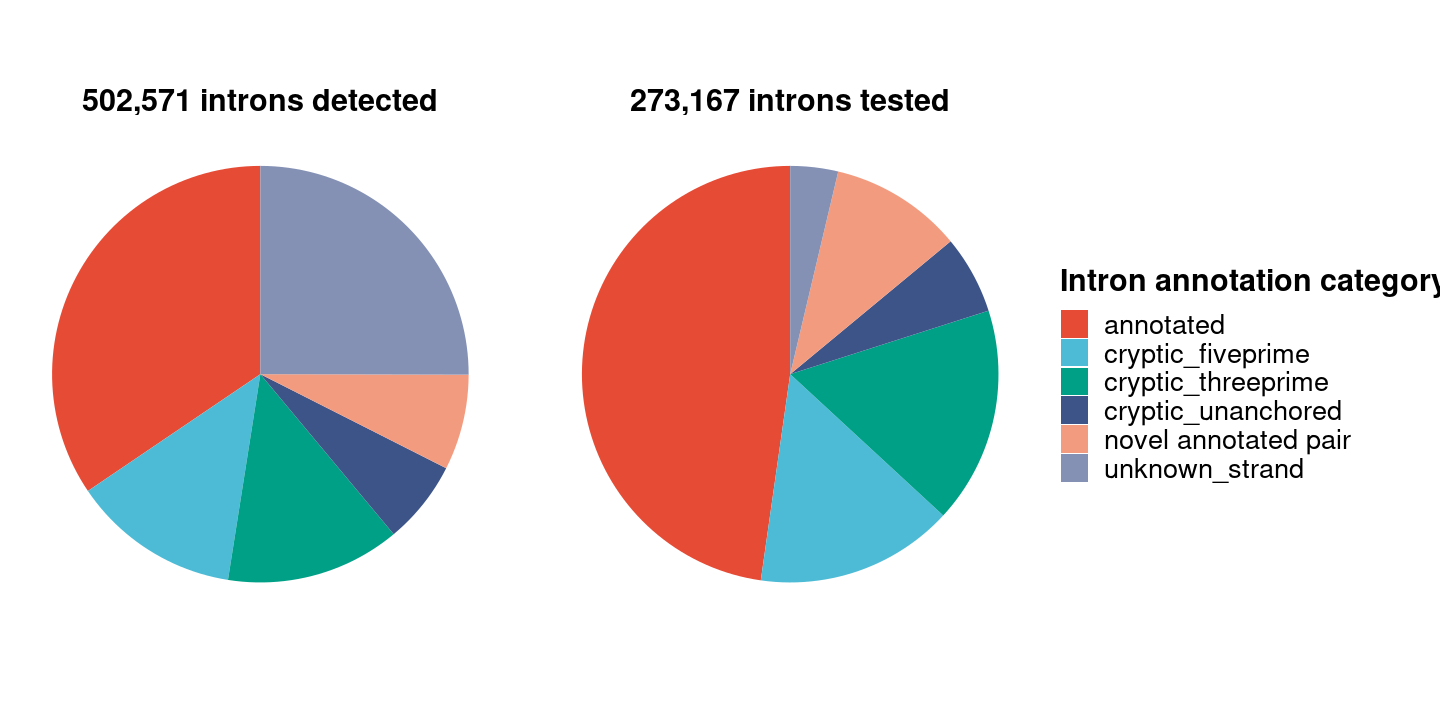

In [64]:
library(ggsci)
options(repr.plot.height = 6, repr.plot.width = 12)

ggplot(df, aes(x = "", y = prop, fill = Var1)) +
  geom_bar(width = 1, stat = "identity") +
  facet_wrap(~group) +
  coord_polar("y", start = 0) +
  theme_void() +
  theme(legend.text = element_text(size = 16),
        legend.title = element_text(size = 18, face = "bold"),
        strip.text.x = element_text(size = 18, face = "bold")) +
#   scale_fill_brewer(palette = "Set1") +
  scale_fill_npg() +
  labs(fill = "Intron annotation category") 
#   ggtitle("Leafcutter intron annotation") 

In [65]:
ggsave("figures/introns_annot.pdf", height = 6, width = 12)

### 6: compare between ancestries

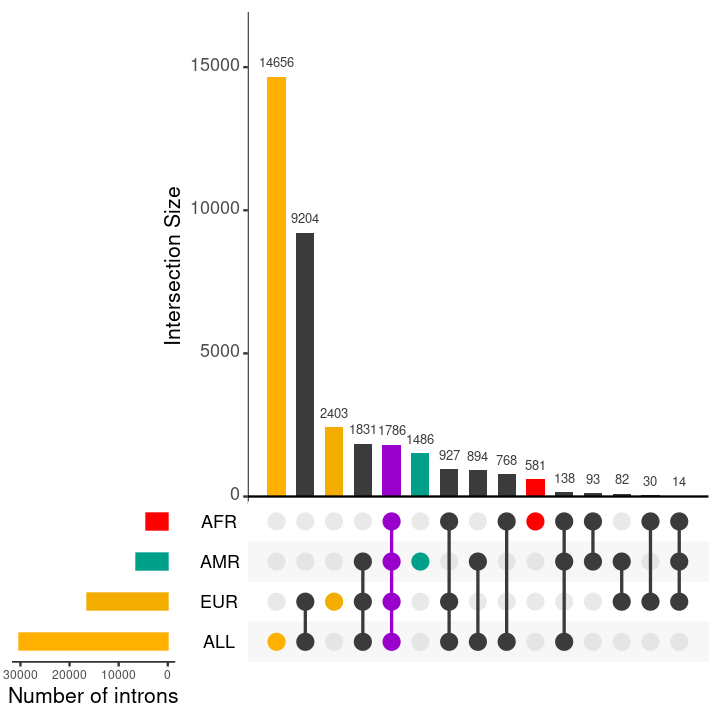

In [73]:
options(repr.plot.width = 6, repr.plot.height = 6)

mixed_intron <- unique(mixed_sig$pid)
eur_intron <- unique(eur_sig$pid)
amr_intron <- unique(amr_sig$pid)
afr_intron <- unique(afr_sig$pid)

intron <- list(ALL = mixed_intron,
            EUR = eur_intron,
            AMR = amr_intron,
            AFR = afr_intron)

upset(fromList(intron), order.by = "freq",
      sets.bar.color = c("#FFB000", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of introns",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#FFB000", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [74]:
pdf(file="figures/upsetr_intron.pdf", onefile=F)
upset(fromList(intron), order.by = "freq",
      sets.bar.color = c("#FFB000", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of introns",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#FFB000", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

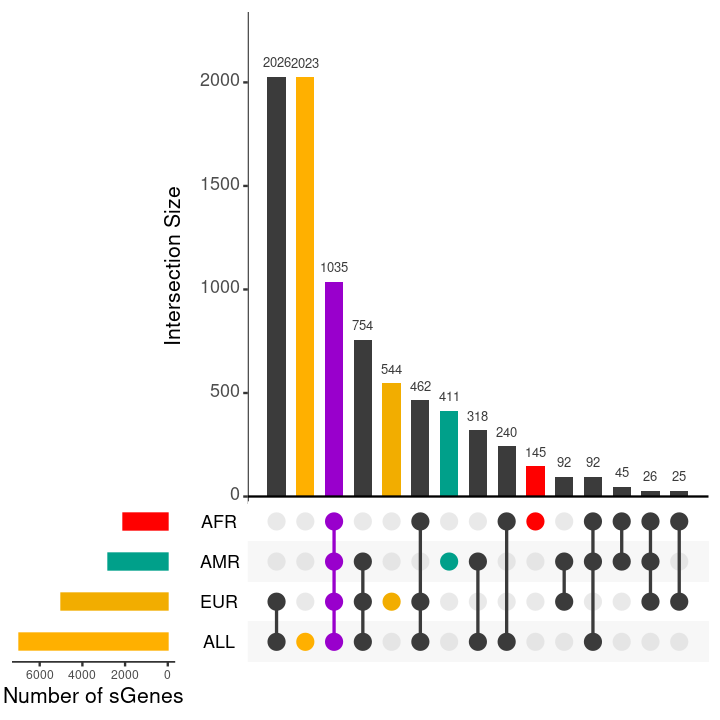

In [71]:
mixed_gene <- unique((all_assoc %>% filter(qval < 0.05) %>% select(ensemblID))$ensemblID)
eur_gene <- unique((all_assoc_eur %>% filter(qval < 0.05) %>% select(ensemblID))$ensemblID)
amr_gene <- unique((all_assoc_amr %>% filter(qval < 0.05) %>% select(ensemblID))$ensemblID)
afr_gene <- unique((all_assoc_afr %>% filter(qval < 0.05) %>% select(ensemblID))$ensemblID)

gene <- list(ALL = mixed_gene,
            EUR = eur_gene,
            AMR = amr_gene,
            AFR = afr_gene)

upset(fromList(gene), order.by = "freq",
      sets.bar.color = c("#FFB000", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of sGenes",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#FFB000", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [72]:
pdf(file="figures/upsetr_sgene.pdf", onefile=F)
upset(fromList(gene), order.by = "freq",
      sets.bar.color = c("#FFB000", "#F2AD00", "#00A08A", "#FF0000"),
      empty.intersections = "on",
      sets.x.label = "Number of sGenes",
      point.size = 4.5,
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "#9900CC", active = T),
                     list(query = intersects, params = list("AFR"),
                          color = "#FF0000", active = T),
                     list(query = intersects, params = list("AMR"),
                          color = "#00A08A", active = T),
                     list(query = intersects, params = list("EUR"),
                          color = "#F2AD00", active = T),
                     list(query = intersects, params = list("ALL"),
                          color = "#FFB000", active = T)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

### 7. Conditional

**Top variants per rank of all introns**
- QTLtools output V3 phenotype TSS is BED start+1
- eQTL conditional V3 is start+1, V4 is end in BED, same number
- sQTL BED files are intron start and end
- Somehow QTLtools conditional output feature's number of SNP in cis is slightly different than FastQTL

In [16]:
dat <- fread("results/mixed_conditional_40hcp_1e6/conditional_top_variants.txt", data.table = F)

In [4]:
table(dat$V2)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
3158 3012 2551 1794 1834 2651 2528 1645 1728 1801 1752 1733  805 1048 1763 1568 
  17   18   19   20   21   22 
1919  523 2322 1059  539 1044 

**Check TSS**

In [22]:
dim(dat)
# variant is SNP, V10==V11, only exception is 7:72304469:72307156:clu_102371_NA, 
# V3 = 72304470, V7 = 0, V10 = 72304470
# total 16144 pairs
sum(dat$V3+dat$V7==dat$V10) 

# total 17305 pairs
# 16143 V10==V11
# 1162 V10 != V11
# variants are indels
sum(dat$V3+dat$V7==dat$V11)

[1] 38777    20

[1] 16144

[1] 17305

In [26]:
# total 17005 pairs, 1088 pairs V10 != V11
sum(dat$V4+dat$V7==dat$V10) 
# total 15917 pairs, all V10 == V11
sum(dat$V4+dat$V7==dat$V11)

[1] 17005

[1] 15917

In [30]:
16144+1162+15917+1088

[1] 34311

In [31]:
# 4462 pairs, all V7=0
# what are these??? They are inside the intron??
# Yes, these are variants inside (most) or overlap with (2, see below) the intron body
sum(!(dat$V3+dat$V7) %in% c(dat$V10, dat$V11) &
    !(dat$V4+dat$V7) %in% c(dat$V10, dat$V11))

sum(!(dat$V3+dat$V7) %in% c(dat$V10, dat$V11) &
    !(dat$V4+dat$V7) %in% c(dat$V10, dat$V11) &
    dat$V7 == 0)

[1] 4462

[1] 4462

In [32]:
test <- dat[!(dat$V3+dat$V7) %in% c(dat$V10, dat$V11) & !(dat$V4+dat$V7) %in% c(dat$V10, dat$V11),]

In [33]:
head(test)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
5,1:727320:741179:clu_7663_NA,1,727321,741179,+,3111,0,rs12131618,1,732809,732809,0,1.88361e-05,0.520703,1,1,1.88361e-05,0.520703,1,1
7,1:764484:776580:clu_7677_NA,1,764485,776580,+,3158,0,rs12124819,1,776546,776546,0,3.06990e-15,-0.635648,1,1,9.86522e-17,-0.667616,1,1
9,1:764484:787307:clu_7677_NA,1,764485,787307,+,3170,0,rs6594026,1,782981,782981,0,5.62258e-14,-0.437266,1,1,5.37269e-16,-0.469703,1,1
10,1:764484:787307:clu_7677_NA,1,764485,787307,+,3170,0,rs138499329,1,772437,772437,1,8.50234e-06,1.087000,1,1,8.50234e-06,1.087000,1,1
13,1:783186:787307:clu_7677_NA,1,783187,787307,+,3170,0,rs6686696,1,783318,783318,0,6.70386e-12,-0.472381,1,1,6.70386e-12,-0.472381,1,1
20,1:840341:850699:clu_7684_NA,1,840342,850699,+,3285,0,rs1574243,1,841085,841085,0,2.50043e-06,-0.277133,1,1,2.50043e-06,-0.277133,1,1


In [34]:
sum(test$V10 == test$V11)

[1] 4184

In [35]:
sum(test$V3<test$V10 & test$V3<test$V11 & test$V4>test$V10 & test$V4 > test$V11)

[1] 4460

In [36]:
which(!(test$V3<test$V10 & test$V3<test$V11 & test$V4>test$V10 & test$V4 > test$V11))

[1]  807 1999

- 7       rs763343282     0       1177827 G       GCGCCCACCTGCGCCCACGT
- 14      chr14:77181894  0       77648237        T       TGTG

In [37]:
test[c(807, 1999),]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
6600,7:1167022:1177835:clu_100267_NA,7,1167023,1177835,+,8261,0,rs763343282,7,1177827,1177846,0,1.99254e-17,-0.464931,1,1,1.99254e-17,-0.464931,1,1
17066,14:77648237:77662414:clu_24164_NA,14,77648238,77662414,+,7417,0,chr14:77181894,14,77648237,77648240,0,5.53106e-115,1.163980,1,1,4.04520e-116,1.167740,1,1


In [6]:
table(dat$V19)
table(dat$V20)


    1 
49864 


    0     1 
   13 49851 

**remove variants with backward P-value that is not below the threshold of this feature**

In [17]:
dat <- dat %>% filter(V20 == 1)

**check features with significant conditional QTL are mostly introns with permutation sQTL**

In [18]:
# length(unique(mixed_sig$pid))
length(unique(dat$V1))
# sum(unique(mixed_sig$pid) %in% unique(dat$V1))

[1] 32558

**How many ranks/independent QTL each feature has? (+1 because primary QTL is rank 0)**

In [19]:
table(dat$V12)


    0     1     2     3     4     5     6     7 
32556  4943   959   227    56    18     7     2 

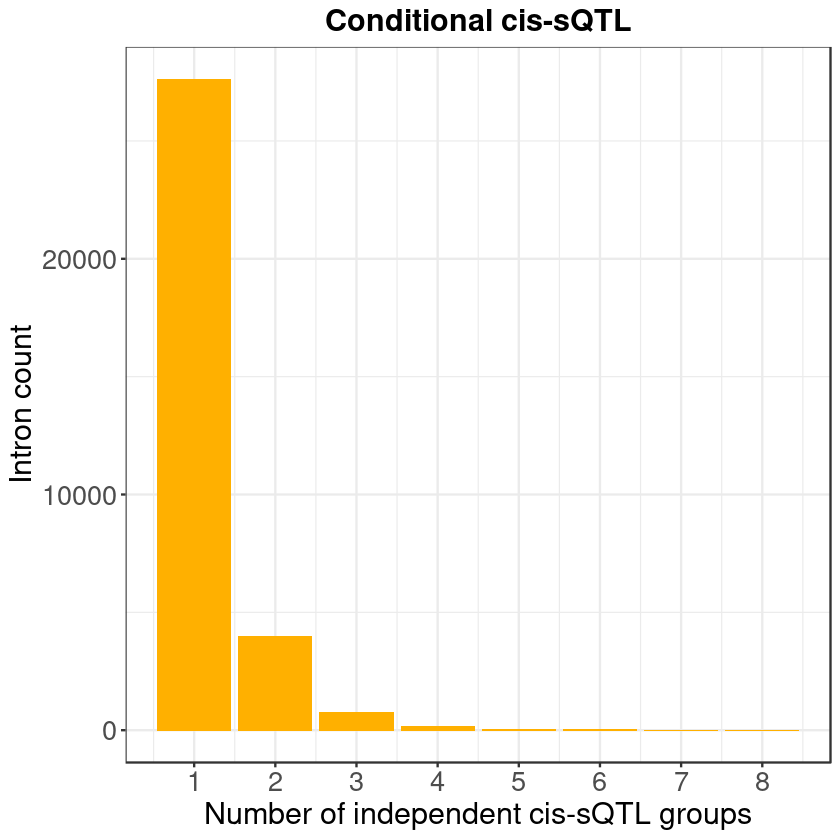

In [20]:
df_cond <- data.frame("intron" <- unique(dat$V1),
                      "num_rank" <- NA)
for (i in 1:nrow(df_cond)) {
  intron <- df_cond[i,1]
  df_cond[i,2] <- max(dat[dat$V1==intron,12]) + 1
}
names(df_cond) <-c("intron","num_rank")

ggplot(df_cond, aes(x = num_rank)) +
  geom_bar(fill = "#FFB000") +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  labs(x = "Number of independent cis-sQTL groups", y = "Intron count") +
  ggtitle("Conditional cis-sQTL") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust=0.5))

In [21]:
table(df_cond$num_rank)


    1     2     3     4     5     6     7     8 
27608  3990   733   169    40    11     5     2 

In [18]:
ggsave("figures/condition_rank.pdf", height = 6, width = 6)

**TSS comparison**

In [22]:
dat2 <- filter(dat, V12 <= 1)
dat2$tss_kb <- dat2$V7/1000

dat2$Rank <- ifelse(dat2$V12==0, "1st", "2nd")

primary <- dat2 %>% filter(Rank == "1st")
secondary <- dat2 %>% filter(Rank == "2nd")
median(primary$tss_kb)
median(secondary$tss_kb)

wilcox.test(abs(primary$tss_kb), abs(secondary$tss_kb), alternative = "two.sided")

[1] 0

[1] 0


	Wilcoxon rank sum test with continuity correction

data:  abs(primary$tss_kb) and abs(secondary$tss_kb)
W = 55588074, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [23]:
table(dat2$Rank)


  1st   2nd 
32556  4943 

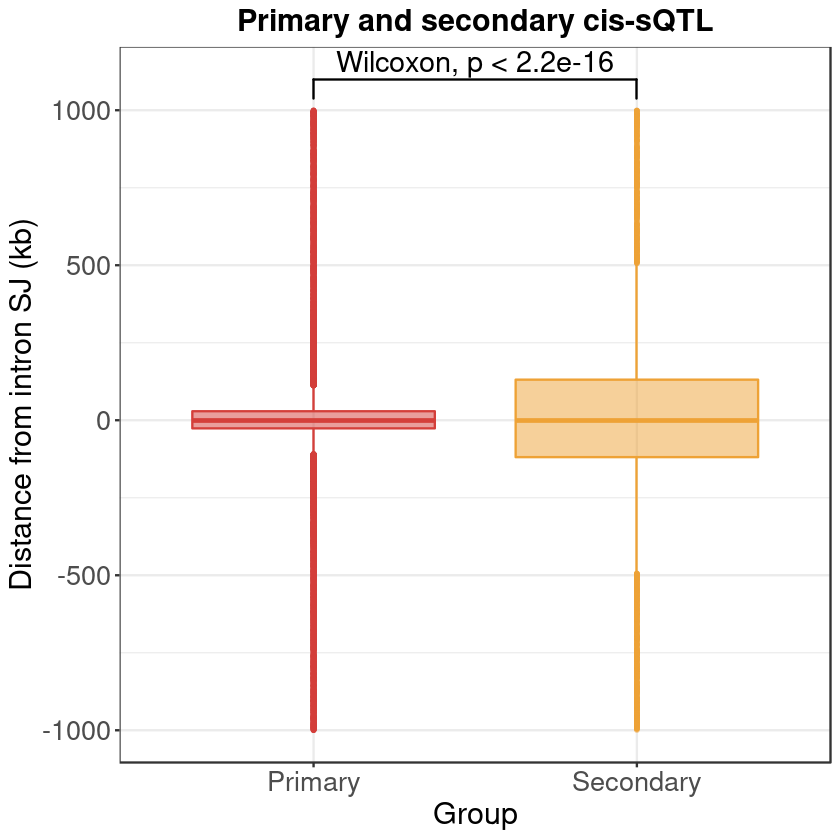

In [21]:
df <- data.frame("Group" = c(rep("Primary", 32556), rep("Secondary", 4943)),
                "TSS_kb" = c(primary$tss_kb, secondary$tss_kb))

ggplot(df, aes(x = Group, y = TSS_kb, color = Group, fill = Group)) +
    geom_boxplot(outlier.shape = 16, outlier.size = 1, alpha = 0.5) +
#     geom_violin(alpha = 0.3, trim = TRUE) +
    theme_bw() +
    labs(x = "Group", y = "Distance from intron SJ (kb)", title = "Primary and secondary cis-sQTL") +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
         legend.position = "none") +
geom_signif(
        comparisons = list(c("Primary", "Secondary")),
        annotation = "Wilcoxon, p < 2.2e-16",
        textsize = 6,
        color = "black"
  ) +
scale_color_locuszoom() +
scale_fill_locuszoom()

In [22]:
ggsave("figures/conditional_dtss_2.pdf", height = 6, width = 6)

In [24]:
dat3 <- filter(dat, V12 <= 3)
dat3$tss_kb <- dat3$V7/1000
dat3 %>% group_by(V12) %>% summarise(median(tss_kb), mean(tss_kb), median(V7), mean(V7))

V12,median(tss_kb),mean(tss_kb),median(V7),mean(V7)
<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.000,0.5960247,0,596.0247
1,0.000,-2.9350530,0,-2935.0530
2,-0.471,-24.9060886,-471,-24906.0886
3,0.000,-5.3784449,0,-5378.4449


In [12]:
dat3 <- dat3 %>% mutate(Rank = case_when(V12 == 0 ~ "Primary, median=0.000, mean=0.596",
                                 V12 == 1 ~ "Secondary, median=0.000, mean=-2.935",
                                 V12 == 2 ~ "Tertiary, median=-0.471, mean=-24.906",
                                 V12 == 3 ~ "Quaternary, median=0.000, mean=-5.378"))
table(dat3$Rank)
dat3$Rank <- factor(dat3$Rank, levels = c("Primary, median=0.000, mean=0.596", 
                                          "Secondary, median=0.000, mean=-2.935", 
                                          "Tertiary, median=-0.471, mean=-24.906", 
                                          "Quaternary, median=0.000, mean=-5.378"))


    Primary, median=0.000, mean=0.596 Quaternary, median=0.000, mean=-5.378 
                                32556                                   227 
 Secondary, median=0.000, mean=-2.935 Tertiary, median=-0.471, mean=-24.906 
                                 4943                                   959 

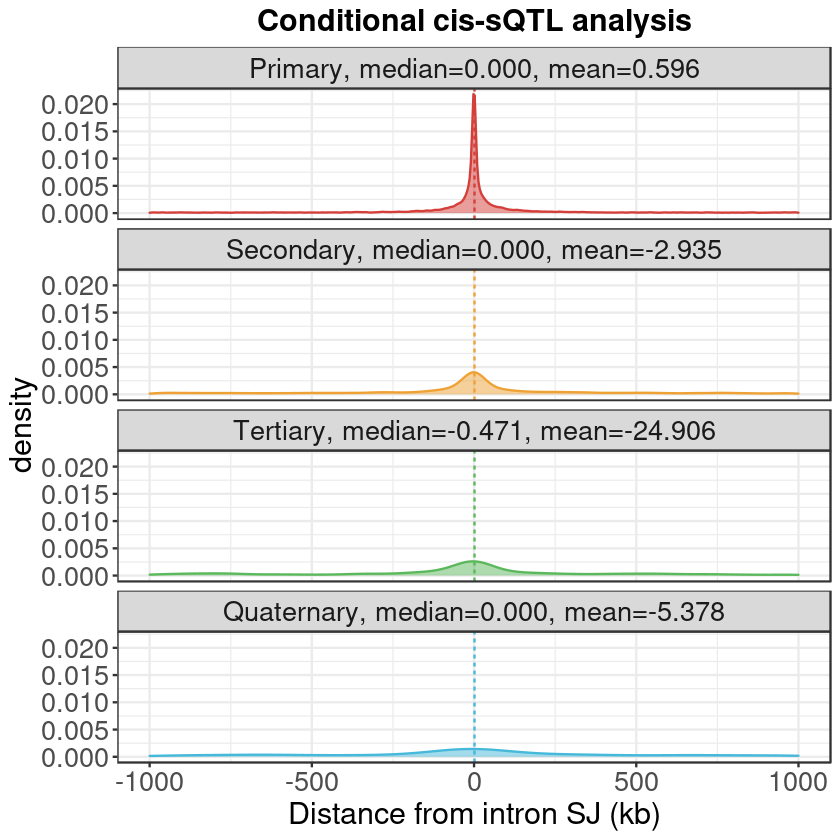

In [13]:
ggplot(dat3, aes(x = tss_kb, fill = Rank, color = Rank)) +
  geom_density(alpha = .5) +
  geom_vline(aes(xintercept = median(tss_kb), color = Rank), linetype = 2, size = .5) +
  facet_wrap(~Rank, nrow = 4) +
  labs(x="Distance from intron SJ (kb)") +
  ggtitle("Conditional cis-sQTL analysis") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.position = "none",
        strip.text.x = element_text(size = 16)) +
scale_color_locuszoom() +
scale_fill_locuszoom()

In [14]:
ggsave("figures/condition_dtss_4.pdf", width = 6, height = 6)

### 8: SuSiE
- We started with 30204 introns identified by FastQTL permutation pass for mixed ancestries with 40 HCP in covariates
- After filtering for CS purity: 
    - 23756 introns have non-low purity CS
    - 26835 unique CS
    - 189531 unique variants in CS    
- Of the 26835 CS:
    - 4582 contain exactly one SNP (strong candidates for causal variants)
    - 2897 contain exactly two SNPs
    - median size 6
- Of the 23756 introns:
    - 21117 have exactly one CS
    - up to 7

In [5]:
sorted_df <- fread("results/susie_finemap/mixed_cissqtl_40hcp_perm_purity_filtered.txt.gz", data.table = F)

In [7]:
length(unique(sorted_df$phenotype_id))

[1] 23756

In [8]:
length(unique(sorted_df$variant_id))

[1] 189531

In [9]:
length(unique(sorted_df$cs_id))

[1] 26835

In [10]:
cs_id_size <- sorted_df[!duplicated(sorted_df$cs_id),] %>% select(cs_id, cs_size, finemapped_region)
sum(cs_id_size$cs_size==1)
sum(cs_id_size$cs_size==2)

[1] 4582

[1] 2897

In [11]:
summary(cs_id_size$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    6.00   20.89   18.00 2017.00 

In [12]:
intron_with_cs <- unique(sorted_df$phenotype_id)
df <- data.frame("intron" = intron_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df[sorted_df$phenotype_id == df[i,1],]$cs_id))
}

In [13]:
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    1.00    1.13    1.00    7.00 

[1] 21117

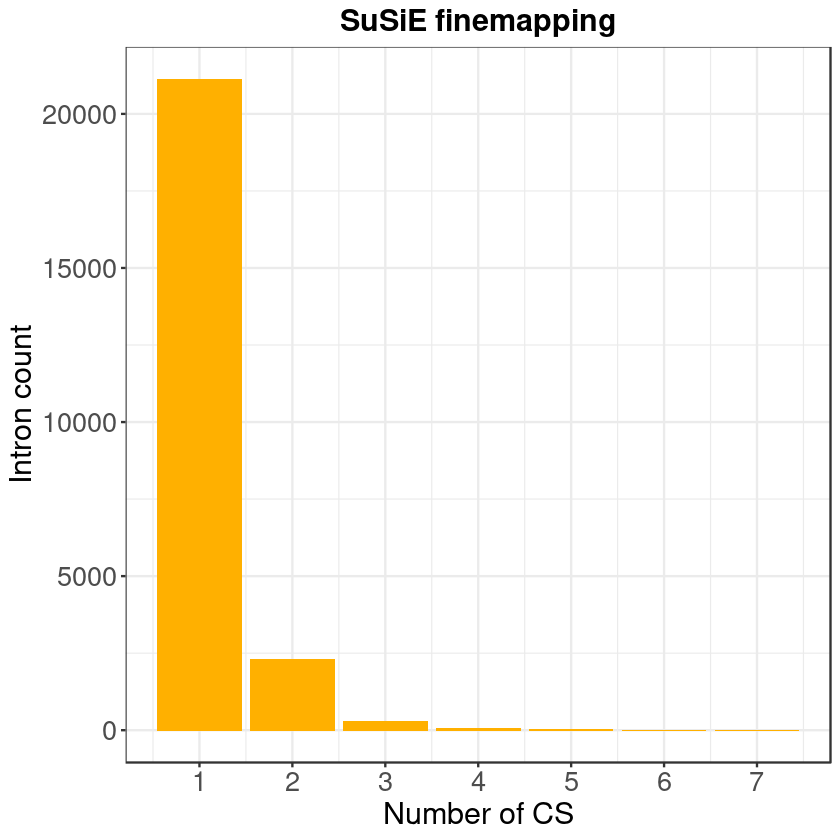

In [14]:
ggplot(df, aes(x = cs_count)) +
  geom_bar(fill = "#FFB000") +
  scale_x_continuous(breaks = seq(1,7,by=1)) +
  labs(x = "Number of CS", y = "Intron count") +
  ggtitle("SuSiE finemapping") +
  theme_bw() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))

In [15]:
ggsave("figures/susie_num_cs.pdf", width = 6, height = 6)

In [25]:
sum(df$intron %in% df_cond$intron)

[1] 22074

In [26]:
df2 <- df %>% inner_join(df_cond)
sum(complete.cases(df2))
dim(df2)

Joining, by = "intron"


[1] 22074

[1] 22074     3


Attaching package: ‘ggpubr’


The following object is masked from ‘package:VennDiagram’:

    rotate


`geom_smooth()` using formula 'y ~ x'



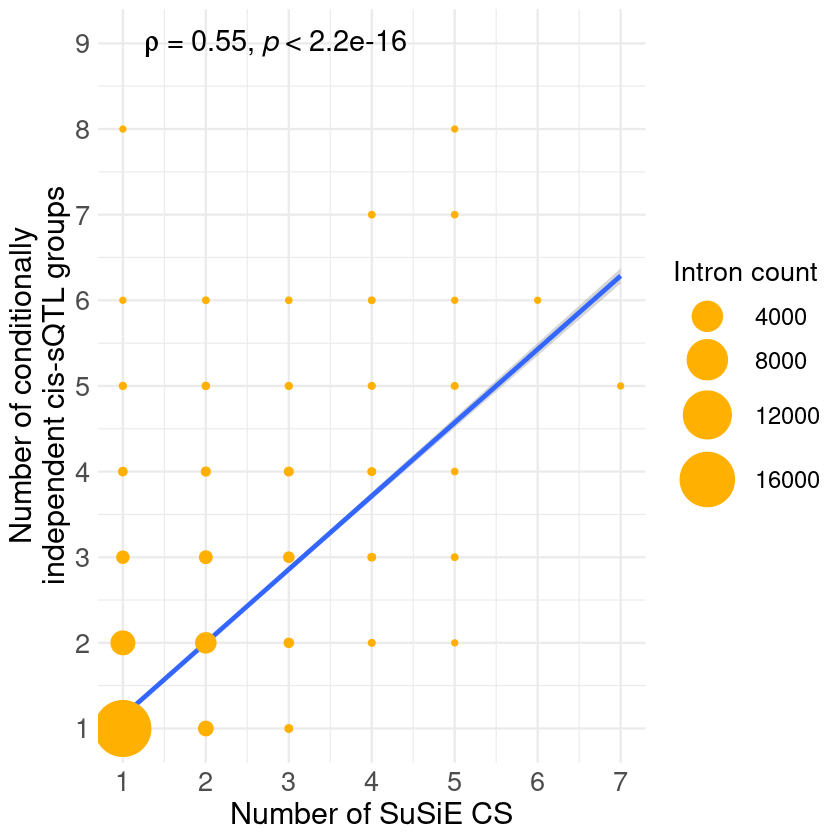

In [27]:
library(ggpubr)

ggplot(df2, aes(x = cs_count, y = num_rank)) +
      geom_smooth(method = "lm", fullrange = TRUE) +
     geom_count(color = "#FFB000") +
     scale_size(range = c(1, 15), "Intron count") + 
  labs(x = "Number of SuSiE CS", y = "Number of conditionally\nindependent cis-sQTL groups") +
  theme_minimal() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)) +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  scale_y_continuous(breaks = seq(1,10,by=1)) +
    stat_cor(method = "spearman", label.x = 1.25, label.y = 9, cor.coef.name = "rho", size = 6)

In [28]:
ggsave("figures/susie_conditional.pdf", width = 8, height = 6)

`geom_smooth()` using formula 'y ~ x'



In [29]:
cor(df2$cs_count, df2$num_rank, method = 'spearman')
cor(df2$cs_count, df2$num_rank, method = 'pearson')

[1] 0.5544722

[1] 0.5982403

In [30]:
cs_sum_pip <- sorted_df %>% group_by(cs_id) %>% summarise(sum_pip = sum(pip))
summary(cs_sum_pip)

    cs_id              sum_pip      
 Length:26835       Min.   :0.9500  
 Class :character   1st Qu.:0.9611  
 Mode  :character   Median :0.9754  
                    Mean   :0.9801  
                    3rd Qu.:0.9961  
                    Max.   :1.8090  

### 11: Compare with GTEx pipeline results (grouping introns into genes)

In [3]:
old <- fread("results/mixed_nominal_5hcp_1e6/chunk1.txt.gz", data.table = F)
dim(old)
colnames(old) <- c("pid","sid","dist","npval","slope")
head(old)

[1] 19362966        5

,pid,sid,dist,npval,slope
,<chr>,<chr>,<int>,<dbl>,<dbl>
1,1:14829:14930:clu_7637_NA,rs61769339,647792,0.270353,-0.0809647
2,1:14829:14930:clu_7637_NA,rs200188737,651419,0.949143,-0.0181878
3,1:14829:14930:clu_7637_NA,rs12238997,678901,0.201556,-0.0939619
4,1:14829:14930:clu_7637_NA,rs61769351,678993,0.169010,-0.0996799
5,1:14829:14930:clu_7637_NA,rs142559957,689807,0.879822,-0.0195469
6,1:14829:14930:clu_7637_NA,rs142576295,693245,0.835547,0.0547918


In [4]:
gtex <- fread("results/gtex_grp/mixed_nominal_5hcp_1e6_chunk001.txt.gz", data.table = F)
dim(gtex)
colnames(gtex) <- c('gene_id', 'variant_id', 'tss_distance', 'ma_samples', 'ma_count', 'maf',
            'pval_nominal', 'slope', 'slope_se')
head(gtex)

[1] 19445217        9

,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:14829:14930:clu_7637_NA:ENSG00000227232.5_3:WASH7P,rs61769339,633052,185,197,0.15390600,0.270353,-0.0809647,0.0733890
2,1:14829:14930:clu_7637_NA:ENSG00000227232.5_3:WASH7P,rs200188737,636679,11,11,0.00859375,0.949143,-0.0181878,0.2850370
3,1:14829:14930:clu_7637_NA:ENSG00000227232.5_3:WASH7P,rs12238997,664161,183,195,0.15234400,0.201556,-0.0939619,0.0734953
4,1:14829:14930:clu_7637_NA:ENSG00000227232.5_3:WASH7P,rs61769351,664253,192,206,0.16093800,0.169010,-0.0996799,0.0723901
5,1:14829:14930:clu_7637_NA:ENSG00000227232.5_3:WASH7P,rs142559957,675067,53,54,0.04218750,0.879822,-0.0195469,0.1292310
6,1:14829:14930:clu_7637_NA:ENSG00000227232.5_3:WASH7P,rs142576295,678505,13,13,0.01015620,0.835547,0.0547918,0.2638290


In [5]:
gtex <- gtex %>% separate(gene_id, into = c("chr","start","end","clu","gene_id","gene_name"), sep = ":") %>%
    unite("intron", chr, start, end, clu, sep = ":")
head(gtex)

,intron,gene_id,gene_name,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs61769339,633052,185,197,0.15390600,0.270353,-0.0809647,0.0733890
2,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs200188737,636679,11,11,0.00859375,0.949143,-0.0181878,0.2850370
3,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs12238997,664161,183,195,0.15234400,0.201556,-0.0939619,0.0734953
4,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs61769351,664253,192,206,0.16093800,0.169010,-0.0996799,0.0723901
5,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs142559957,675067,53,54,0.04218750,0.879822,-0.0195469,0.1292310
6,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs142576295,678505,13,13,0.01015620,0.835547,0.0547918,0.2638290


In [6]:
old <- old %>% unite("intron_variant", pid, sid, sep = ":", remove = FALSE)
head(old)

,intron_variant,pid,sid,dist,npval,slope
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,1:14829:14930:clu_7637_NA:rs61769339,1:14829:14930:clu_7637_NA,rs61769339,647792,0.270353,-0.0809647
2,1:14829:14930:clu_7637_NA:rs200188737,1:14829:14930:clu_7637_NA,rs200188737,651419,0.949143,-0.0181878
3,1:14829:14930:clu_7637_NA:rs12238997,1:14829:14930:clu_7637_NA,rs12238997,678901,0.201556,-0.0939619
4,1:14829:14930:clu_7637_NA:rs61769351,1:14829:14930:clu_7637_NA,rs61769351,678993,0.169010,-0.0996799
5,1:14829:14930:clu_7637_NA:rs142559957,1:14829:14930:clu_7637_NA,rs142559957,689807,0.879822,-0.0195469
6,1:14829:14930:clu_7637_NA:rs142576295,1:14829:14930:clu_7637_NA,rs142576295,693245,0.835547,0.0547918


In [7]:
gtex <- gtex %>% unite("intron_variant", intron, variant_id, sep = ":", remove = FALSE)
head(gtex)

,intron_variant,intron,gene_id,gene_name,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:14829:14930:clu_7637_NA:rs61769339,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs61769339,633052,185,197,0.15390600,0.270353,-0.0809647,0.0733890
2,1:14829:14930:clu_7637_NA:rs200188737,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs200188737,636679,11,11,0.00859375,0.949143,-0.0181878,0.2850370
3,1:14829:14930:clu_7637_NA:rs12238997,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs12238997,664161,183,195,0.15234400,0.201556,-0.0939619,0.0734953
4,1:14829:14930:clu_7637_NA:rs61769351,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs61769351,664253,192,206,0.16093800,0.169010,-0.0996799,0.0723901
5,1:14829:14930:clu_7637_NA:rs142559957,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs142559957,675067,53,54,0.04218750,0.879822,-0.0195469,0.1292310
6,1:14829:14930:clu_7637_NA:rs142576295,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs142576295,678505,13,13,0.01015620,0.835547,0.0547918,0.2638290


**Does grouping affect nominal results? i.e. for same intron-variant pair, does it have different nominal p-val in different groups?**
- Answer: no. Features like intron:gene1, intron:gene2 have the same phenotype in BED file, and have the same nominal association with the same variants. Variants may be different though, as cis-variant set is based on gene TSS.

In [9]:
dim(gtex)
length(unique(gtex$intron_variant))
head(gtex[duplicated(gtex$intron_variant),])

[1] 19445217       12

[1] 17899991

,intron_variant,intron,gene_id,gene_name,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
29673,1:92240:112700:clu_7642_NA:rs61769339,1:92240:112700:clu_7642_NA,ENSG00000241860.7_7,AL627309.5,rs61769339,488760,185,197,0.15390600,0.0940796,-0.1308460,0.0780331
29674,1:92240:112700:clu_7642_NA:rs200188737,1:92240:112700:clu_7642_NA,ENSG00000241860.7_7,AL627309.5,rs200188737,492387,11,11,0.00859375,0.5974060,-0.1603140,0.3033930
29675,1:92240:112700:clu_7642_NA:rs12238997,1:92240:112700:clu_7642_NA,ENSG00000241860.7_7,AL627309.5,rs12238997,519869,183,195,0.15234400,0.1196690,-0.1218520,0.0781959
29676,1:92240:112700:clu_7642_NA:rs61769351,1:92240:112700:clu_7642_NA,ENSG00000241860.7_7,AL627309.5,rs61769351,519961,192,206,0.16093800,0.2755190,-0.0841596,0.0771120
29677,1:92240:112700:clu_7642_NA:rs142559957,1:92240:112700:clu_7642_NA,ENSG00000241860.7_7,AL627309.5,rs142559957,530775,53,54,0.04218750,0.1252060,-0.2108440,0.1373270
29678,1:92240:112700:clu_7642_NA:rs142576295,1:92240:112700:clu_7642_NA,ENSG00000241860.7_7,AL627309.5,rs142576295,534213,13,13,0.01015620,0.8163810,-0.0652479,0.2808780


In [10]:
gtex %>% filter(intron_variant == "1:92240:112700:clu_7642_NA:rs61769339")

intron_variant,intron,gene_id,gene_name,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1:92240:112700:clu_7642_NA:rs61769339,1:92240:112700:clu_7642_NA,ENSG00000238009.6_9,AL627309.1,rs61769339,528899,185,197,0.153906,0.0940796,-0.130846,0.0780331
1:92240:112700:clu_7642_NA:rs61769339,1:92240:112700:clu_7642_NA,ENSG00000241860.7_7,AL627309.5,rs61769339,488760,185,197,0.153906,0.0940796,-0.130846,0.0780331


In [11]:
length(unique(old$intron_variant))

[1] 19362966

In [12]:
gtex <- gtex[!duplicated(gtex$intron_variant),]

In [13]:
dim(gtex)

[1] 17899991       12

In [14]:
merged <- gtex %>% inner_join(old, by="intron_variant")
head(merged)
dim(merged)

,intron_variant,intron,gene_id,gene_name,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope.x,slope_se,pid,sid,dist,npval,slope.y
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,1:14829:14930:clu_7637_NA:rs61769339,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs61769339,633052,185,197,0.15390600,0.270353,-0.0809647,0.0733890,1:14829:14930:clu_7637_NA,rs61769339,647792,0.270353,-0.0809647
2,1:14829:14930:clu_7637_NA:rs200188737,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs200188737,636679,11,11,0.00859375,0.949143,-0.0181878,0.2850370,1:14829:14930:clu_7637_NA,rs200188737,651419,0.949143,-0.0181878
3,1:14829:14930:clu_7637_NA:rs12238997,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs12238997,664161,183,195,0.15234400,0.201556,-0.0939619,0.0734953,1:14829:14930:clu_7637_NA,rs12238997,678901,0.201556,-0.0939619
4,1:14829:14930:clu_7637_NA:rs61769351,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs61769351,664253,192,206,0.16093800,0.169010,-0.0996799,0.0723901,1:14829:14930:clu_7637_NA,rs61769351,678993,0.169010,-0.0996799
5,1:14829:14930:clu_7637_NA:rs142559957,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs142559957,675067,53,54,0.04218750,0.879822,-0.0195469,0.1292310,1:14829:14930:clu_7637_NA,rs142559957,689807,0.879822,-0.0195469
6,1:14829:14930:clu_7637_NA:rs142576295,1:14829:14930:clu_7637_NA,ENSG00000227232.5_3,WASH7P,rs142576295,678505,13,13,0.01015620,0.835547,0.0547918,0.2638290,1:14829:14930:clu_7637_NA,rs142576295,693245,0.835547,0.0547918


[1] 17407532       17

In [15]:
# p <- ggplot(merged, aes(x = pval_nominal, y = npval)) +
#     geom_point() +
#     theme_classic() +
#     labs(x = "GTEx npval", y = "FastQTL npval")